# BRIDGET: Compas

no duplicates ver


## Dataset Preprocessing


### Libraries, Retrieving data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import yaml
import joblib
import random
import time
import functools
import pickle
import re
import orjson
import alibi
import ignite
import copy

from IPython import display
from itertools import combinations, product
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import Counter

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optimizer

import fatf.utils.data.datasets as fatf_datasets
import fatf.fairness.data.measures as fatf_dfm
import fatf.utils.data.tools as fatf_data_tools

from river import rules, tree, datasets, drift, metrics, evaluate
from river import imblearn
from river import preprocessing
from river import optim
from river import metrics
from river import feature_extraction, feature_selection
from river import ensemble, linear_model, forest, compose

from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from ignite.metrics import Accuracy, Loss
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint
from ignite.contrib.handlers import global_step_from_engine


from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper

from alibi.explainers.cfproto import CounterFactualProto

from bridget_utils import *
from classes import BetaUser, DeferralNet, PyTorchWrapper, RiverModelWrapper, PriorityManager
from b_xai_test import BRIDGET, HiC, MiC


c:\Users\virgm\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


26-Feb-20 22:24:11 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [3]:
set_all_seeds(42)

In [4]:
data= pd.read_csv(r".\datasets\recidivism-risk_odsc.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14788 entries, 0 to 14787
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sex              14788 non-null  object
 1   age              14788 non-null  int64 
 2   race             14788 non-null  object
 3   juv_fel_count    14788 non-null  int64 
 4   juv_misd_count   14788 non-null  int64 
 5   juv_other_count  14788 non-null  int64 
 6   priors_count     14788 non-null  int64 
 7   c_charge_degree  14788 non-null  object
 8   compas_score     14788 non-null  int64 
 9   did_recid        14788 non-null  int64 
dtypes: int64(7), object(3)
memory usage: 1.1+ MB


In [5]:
for c in data:
    print(data[c].value_counts().sum)

<bound method Series.sum of sex
Male      12093
Female     2695
Name: count, dtype: int64>
<bound method Series.sum of age
22    780
21    762
26    741
24    738
25    724
     ... 
96      2
78      1
83      1
80      1
79      1
Name: count, Length: 65, dtype: int64>
<bound method Series.sum of race
African-American    8004
Caucasian           4848
Hispanic            1083
Other                763
Asian                 57
Native American       33
Name: count, dtype: int64>
<bound method Series.sum of juv_fel_count
0     14176
1       390
2       135
3        46
4        19
5         9
8         4
10        4
6         3
20        1
13        1
Name: count, dtype: int64>
<bound method Series.sum of juv_misd_count
0     13854
1       643
2       174
3        57
4        23
8        11
6         9
5         8
12        4
7         3
13        2
Name: count, dtype: int64>
<bound method Series.sum of juv_other_count
0     13494
1       902
2       251
3        81
4        38
5         7

### Preprocessing Pipeline
1. Drop duplicates

2. Drop 'compas_score'

3. Clean 'c_charge_degree' values

4. Map 'sex', 'race', 'c_charge_degree'


In [6]:
data= clean_compas(data, 'compas_score', col_to_strip= 'c_charge_degree', drop_duplicates=True)

In [7]:
data.info()
data.head(n=5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5417 entries, 0 to 5416
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sex              5417 non-null   object
 1   age              5417 non-null   int64 
 2   race             5417 non-null   object
 3   juv_fel_count    5417 non-null   int64 
 4   juv_misd_count   5417 non-null   int64 
 5   juv_other_count  5417 non-null   int64 
 6   priors_count     5417 non-null   int64 
 7   c_charge_degree  5417 non-null   object
 8   did_recid        5417 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 381.0+ KB


,sex,age,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree,did_recid
0,Male,69,Other,0,0,0,0,F3,0
1,Male,34,African-American,0,0,0,0,F3,1
2,Male,24,African-American,0,0,1,4,F3,1
3,Male,44,Other,0,0,0,0,M1,0
4,Male,41,Caucasian,0,0,0,14,F3,1


In [8]:
# WRT c_charge_degree's preprocessing

# so F stands for Felony, M for Misdemeanor. Codes from Florida State Statues
# CO for County Ordinance, MO Municipal Ordinance, X/TCX non specified, NI0 Non infraction or sthm
# the last codes from the Broward County Statute, probably the least severe charges


#  increasing order for gender, race

mapping= { 'sex': {'Female':0, 'Male':1},
           
            'race': {'Native American': 0,
            'Asian': 1,
            'Other': 2,
            'Hispanic': 3,
            'Caucasian': 4,
            'African-American': 5  },

            'c_charge_degree': {
                'X': 0, 'TCX': 0, 'NI0': 0, 'MO3': 0, 'CO3': 0, 

                'M2': 1,   
                'M1': 2,  
                'F5': 3, 'F6': 3,'F3': 3,                    
                                    
                'F7': 4, 'F2': 4, # apparently lvl 7 felonies can get u up to 15 years in prison                                                  
                'F1': 5
                }

}

data= apply_map(data, mapping)

            

the initial map for the charges:

charges_map= {
    'X': 0, 'TCX': 0, 'NI0': 0,    
    'MO3': 1, 'CO3': 1, 

    'M2': 2,   
    'M1': 3,  
    'F5': 4,                   
    'F6': 5,                       
    'F3': 6,  
    'F7': 7,  # apparently lvl 7 felonies can get u up to 15 years in prison                                   
    'F2': 8,                 
    'F1': 9

}

after assessing the distribution of the values, ive decided to merge the least frequent ones so as to avoid high cardinality 

Felony offenses not listed in section 921.0022, Florida Statutes, are assigned a severity level in
accordance with section 921.0023, Florida Statutes, as follows:
(A) A felony of the third degree within offense level 1.
(B) A felony of the second degree within offense level 4.
(C) A felony of the first degree within offense level 7.
(D) A felony of the first degree punishable by life within offense level 9.
(E) A life felony within offense level 10

https://brycefetter.com/wp-content/uploads/2019/05/Offense-Severity-Chart.pdf

point system:
https://brycefetter.com/floridas-criminal-punishment-scoresheet/

So F1, F2 and F3 are the 3 degrees of Felony, while 5,6,7 are levels so it should go 5 --> 6--> 7 in increasing order of the severity of the offence

Encode: Gender, Race, c_charge_degree

Ordinal: juv_fel_count, juv_misd_count, juv_other_count, priors_count

Drop compas_score for now

Scaling w Min Max (hence should modify weights)

### Splitting and Transforming data

1. Apply stratified sampling

2. Get pre-training/HiC/calibration/Mic data

3. Apply scaler

4. Get X, y

In [9]:
# Qui definiamo i vari split dei flussi 

data = data.sample(frac=1, random_state=42).reset_index(drop=True) # shuffle iniziale

class_0 = data[data['did_recid'] == 0]
class_1= data[data['did_recid'] == 1]

#  split ufficiale

splits= {
    'calibration': (0.6, 0.8),
    'mic': (0.8, 1.0),
    'avv_train': (0.0, 0.07),
    'avv_test': (0.07, 0.1),
    'hic_train': (0.1, 0.5),
    'hic_test': (0.5, 0.6)
}

dfs= {}

for name, (start, end) in splits.items():
    dfs[name]= stratif(start, end, class_0, class_1)



In [10]:
for name, df in dfs.items():
    print(f"{name} length: {len(df)}")


calibration length: 1083
mic length: 1085
avv_train length: 378
avv_test length: 163
hic_train length: 2167
hic_test length: 541


In [11]:
target= 'did_recid'
categoricals= ['sex', 'race', 'c_charge_degree']
numericals= [c for c in data if c not in categoricals and c != target]


prepr_transf = (
    (compose.Select(*numericals, *categoricals) | preprocessing.MinMaxScaler())
)

In [12]:
## ora divisione in x e y

# avviamento 
X_avv_train, y_avv_train = x_y_split(dfs['avv_train'], target)
X_avv_test, y_avv_test = x_y_split(dfs['avv_test'], target)


# hic
X_hic_train, y_hic_train = x_y_split(dfs['hic_train'], target)
X_hic_test, y_hic_test = x_y_split(dfs['hic_test'], target)

# validation
X_val, y_val = x_y_split(dfs['calibration'], target)

# mic
X_mic, y_mic = x_y_split(dfs['mic'], target)



## Calibration Phase: Experts and Incremental Model Selection

### Calibrating Incremental Model

The incremental model to be chosen for Bridget is trained on the X_avv, y_avv portion of the dataset,then evaluated on the X_avv_test and y_avv_test

The calibration phase starts by assessing the results of the learning for several configurations:

    - HoeffdingTreeClassifier

    - ExtremelyFastDecisionTreeClassifier

    - AdaBoostClassifier            (base= SGTClassifier)

    - AdwinBaggingClassifier        (base= SGTClassifier)

    - SRPClassifier                 (base= SGTClassifier)

    - AdaptiveRandomForestClassifier


The metrics observed are the Accuracy, the F1Score and the Counters for the classes

In [13]:
# since all River models work with dicts, lets first transform the dfs to dict

X_avv_dict= X_avv_train.to_dict(orient='records')
X_avv_dict_test= X_avv_test.to_dict(orient='records')

df_batch_1 = (dfs['hic_train']).reset_index(drop=True)
mic_data= dfs['mic'].reset_index(drop=True)
df_avv= pd.concat([dfs['avv_train'], dfs['avv_test']]).reset_index(drop=True)

test_batch_1= X_hic_test.copy()
test_batch_1[target]= y_hic_test


# setting the init params required by HIC class
RULE = False
PAST = True
SKEPT = True
GROUP = True
EVA=    True
N_BINS = 10
N_VAR = 3
MAX = 5

rule_att = 'priors_count' #random rule
rule_value = -0.7

protected= ['race', 'age', 'sex']


In [14]:
# then the models are instantiated and trained by the HiC.train function
# the HiC object is initialized by passing a random user model, its not relevant since it won't interact with the IL anyways

set_all_seeds(42)

expert= 'accurate_trusting'

base = tree.HoeffdingTreeClassifier(grace_period=100)

htree= tree.HoeffdingAdaptiveTreeClassifier(grace_period= 100, seed= 42)
efdt= tree.ExtremelyFastDecisionTreeClassifier(grace_period=100)
ada= ensemble.AdaBoostClassifier(model= base, n_models= 15, seed= 42)  
adwin= ensemble.ADWINBaggingClassifier(model= base, n_models= 15, seed= 42)
srp= ensemble.SRPClassifier(model= base, n_models=15, seed= 42)
arf= forest.ARFClassifier(n_models= 15, grace_period= 100, max_features='sqrt', seed=42)

models= [htree, efdt, ada, adwin, srp, arf]


for model in models:
    
    bridget_inst= HiC(RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, 'placeholder', model,
                start_performance= 65,
                allocated_budget= 722,
                skepticism_threshold= 0.6,
                performance_delta= 0.05,
                dataset_name= 'compas',
                user_name= 'placeholder',
                df_batch1=df_batch_1, df_batch3=mic_data, batch1_test=test_batch_1, 
                target=target, 
                user_model='placeholder', 
                protected=protected, cats=categoricals, num=numericals,
                preprocessor=prepr_transf,
                training_iter= 0 
                )
    
    bridget_inst.train(X_avv_dict, y_avv_train, X_avv_dict_test, y_avv_test)

trained_arf= arf

Accuracy: 60.12%
F1: 31.58%
Distribution of predictions: Counter({0: 135, 1: 28})
HoeffdingAdaptiveTreeClassifier trained
Accuracy: 63.19%
F1: 40.00%
Distribution of predictions: Counter({0: 130, 1: 33})
ExtremelyFastDecisionTreeClassifier trained
Accuracy: 68.10%
F1: 55.17%
Distribution of predictions: Counter({0: 114, 1: 49})
AdaBoostClassifier(HoeffdingTreeClassifier) trained
Accuracy: 60.74%
F1: 33.33%
Distribution of predictions: Counter({0: 134, 1: 29})
ADWINBaggingClassifier(HoeffdingTreeClassifier) trained
Accuracy: 61.96%
F1: 38.00%
Distribution of predictions: Counter({0: 130, 1: 33})
SRPClassifier(HoeffdingTreeClassifier) trained
Accuracy: 61.96%
F1: 45.61%
Distribution of predictions: Counter({0: 116, 1: 47})
ARFClassifier trained


### Calibrating Experts

For the Adult dataset the .search_bounds function was not capable to find the bounds at all, even after doubling the search range and running 10 iters

Thus i pre-trained the IL models first, which update the scaler, then transformed the columns for the expert to be fitted on

In [15]:
with open(r".\experts_compas.yaml", "r") as f:
    config= yaml.safe_load(f)


params_dict= config['experts']['groups']['w_dict']


In [16]:
#expert_data= pd.concat([df_0, df_1]).sample(frac=1, random_state=42).reset_index(drop=True)

X_exp= X_hic_train.to_dict(orient='records')

X_exp_scaled= []

for x in X_exp:
    X_exp_scaled.append(prepr_transf.transform_one(x))

X_exp_final = pd.DataFrame(X_exp_scaled)

In [17]:
experts_obj= {}

expert_names = ['accurate_trusting', 'accurate_not_trusting', 
                'inaccurate_trusting', 'inaccurate_not_trusting']

for name in expert_names:
    expert_type= config['experts']['groups'][name]

    experts_obj[name]= BetaUser(
        belief_level= expert_type['belief_value'],
        rethink_level= 0.8, # as suggested by the og FRANK implementation
        fairness= True,
        fpr= expert_type['target_FPR'],
        fnr= expert_type['target_FNR'],
        alpha= 0.9,
        features_dict= params_dict,
        seed= expert_type['group_seed']
        )
    res = experts_obj[name].fit(X_exp_final, y_hic_train, tol= 0.001)
    
    print(f"{'='*30}")
    print(f" EXPERT CALIBRATION REPORT ")
    print(f"{'='*30}")

    print(f"\n[EXPERT: {name}]")
    print(f"\n[FALSE POSITIVE RATE]")
    print(f"  - Iters:      {res['fpr iters number']}")
    print(f"  - Beta:       {res['calibrated_fpr_beta']:.4f}")
    print(f"  - Target:     {res['target_fpr']}")
    print(f"  - Achieved:   {res['achieved_fpr']:.4f}")

    print(f"\n[FALSE NEGATIVE RATE]")
    print(f"  - Iters:      {res['fnr iters number']}")
    print(f"  - Beta:       {res['calibrated_fnr_beta']:.4f}")
    print(f"  - Target:     {res['target_fnr']}")
    print(f"  - Achieved:   {res['achieved_fnr']:.4f}")
    


 EXPERT CALIBRATION REPORT 

[EXPERT: accurate_trusting]

[FALSE POSITIVE RATE]
  - Iters:      11
  - Beta:       -3.2227
  - Target:     0.05
  - Achieved:   0.0500

[FALSE NEGATIVE RATE]
  - Iters:      13
  - Beta:       -2.6123
  - Target:     0.05
  - Achieved:   0.0500
 EXPERT CALIBRATION REPORT 

[EXPERT: accurate_not_trusting]

[FALSE POSITIVE RATE]
  - Iters:      13
  - Beta:       -3.0518
  - Target:     0.05
  - Achieved:   0.0500

[FALSE NEGATIVE RATE]
  - Iters:      13
  - Beta:       -2.8076
  - Target:     0.05
  - Achieved:   0.0499
 EXPERT CALIBRATION REPORT 

[EXPERT: inaccurate_trusting]

[FALSE POSITIVE RATE]
  - Iters:      14
  - Beta:       -1.2329
  - Target:     0.3
  - Achieved:   0.3002

[FALSE NEGATIVE RATE]
  - Iters:      15
  - Beta:       -0.3845
  - Target:     0.3
  - Achieved:   0.3000
 EXPERT CALIBRATION REPORT 

[EXPERT: inaccurate_not_trusting]

[FALSE POSITIVE RATE]
  - Iters:      14
  - Beta:       -1.1108
  - Target:     0.3
  - Achieved:   

## BRIDGET decision making



### Expert: Accurate, Trusting 

budgets --> 722, 722, 723
:722, 722:1444, 1444:

#### Iter 1

##### HiC, 722 record batch

In [ ]:
# defining necessary instantiation params for HiC class
hic_iter= 1

clean_prepr = copy.deepcopy(prepr_transf)
arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['accurate_trusting']
name= "accurate_trusting"
mod_name="ARF"


hic_inst= HiC(RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, 
                mod_name, arf_mod,
                start_performance= 65,
                allocated_budget= 722,
                skepticism_threshold= 0.2,
                performance_delta= 0.05,
                dataset_name= 'compas',
                user_name= name,
                df_batch1=df_batch_1, df_batch3=mic_data, batch1_test=test_batch_1, 
                target=target, 
                user_model=current_expert, 
                protected=protected, cats=categoricals, num=numericals,
                preprocessor=prepr_transf,
                training_iter= hic_iter 
                    )

In [ ]:
acc_t, _, equality, skept_count= hic_inst.start_HiC(df_avv)  

# saving the results in their folder 
path= f".\processed_data\compas\hic_results_ds\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"hic_{name}.csv")

acc_t.to_csv(file_path, index=False)

 34%|███▍      | 733/2167 [01:59<03:54,  6.13it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: HiC
Current desired perfomance: 68.25
Last 5 FEA values: [0.629982102930605, 0.6336849749463411, 0.637350764611709, 0.6409798438186015, 0.644572580718697]


In [ ]:
equality

[]

In [ ]:
skept_count #none overcame the skept threshold set at 0.6

64

Applying learned scaler to the calibration and mic batches

In [ ]:
# retrieving the preprocessor

prepr_path= fr"HIC_res\compas\iter_{hic_iter}\results_accurate_trusting\HIC_DRIFT_User_accurate_trusting_ARFpreprocessor.pkl"
trained_preprocessor = joblib.load(prepr_path)

df_batch_3= scale_df(mic_data, hic_inst.preprocessor, target)
df_batch_3= apply_order(df_batch_3)

df_calibration= scale_df(dfs['calibration'], hic_inst.preprocessor,target)
df_calibration= apply_order(df_calibration)


path= f".\processed_data\compas\calibration_datasets\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"acc_t_calibration.csv")

df_calibration.to_csv(file_path, index=False)


# applying scaler to calibration batch 3

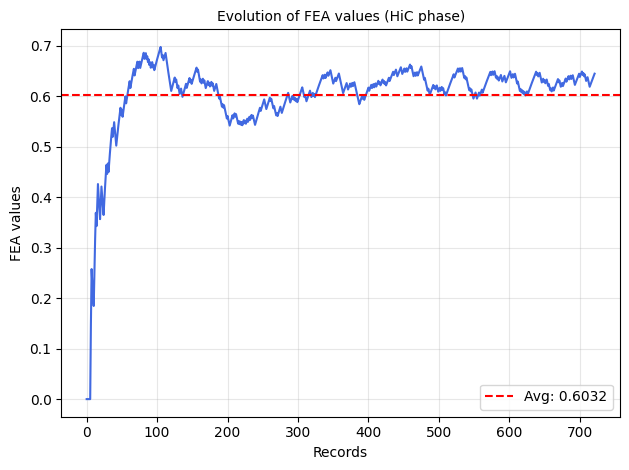

In [ ]:
plt.plot(hic_inst.machine_fea, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_inst.machine_fea)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.axhline(y= avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)  
plt.tight_layout()
plt.show()

# forgot to change the name again 

##### MiC

In [ ]:
mic_iter= 1

acc_t_switch= pd.read_csv(fr".\processed_data\compas\switch_ds\iter_{mic_iter}\acc_t_switch.csv")

device = torch.device("cpu")
# prendo la struttura della mic 
mic_net = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=2, dropout_coeff= 0.0) #tanto va in eval non serve il dropout
mic_net.to(device)


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [ ]:
X_stream= torch.tensor(data= df_batch_3.drop(columns=['did_recid']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['did_recid'].values, dtype= torch.long).to(device)


net_path= fr".\nets\compas\iter_{mic_iter}\acc_t_models\32_16_acc_t_model_36.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Confidence based Deferral

Tau = 0.62

batches: 361, 362, 362 rec

In [ ]:
acc_t_mic= MiC(mic_net, 'Def_Net', 
               benchmark_performance= 65, #nel primo run è irrilevante
                 user_patience= 361,
                 performance_delta= 0.05,
                 belief_threshold= 0.6,
                 tau_threshold= 0.62,
                 anqi_mao_thresh=None, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= mic_iter
 )



acc_t_mic_df =acc_t_mic.start_MiC(X_stream, y_stream, acc_t_switch)   #3 minutes

 41%|████▏     | 448/1085 [01:41<02:24,  4.42it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.6
Last 5 FEA values: [0.8250601493427674, 0.8268295521560189, 0.828580858349376, 0.8303142570359479, 0.8320299352715095]


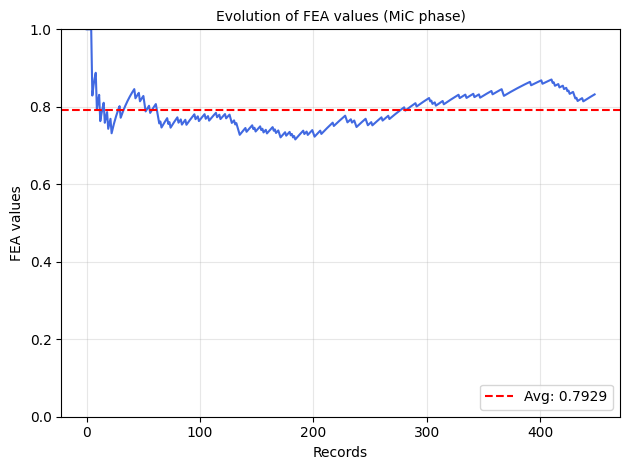

In [ ]:
plt.plot(acc_t_mic.fea_mic, linestyle='-', color='royalblue')

avg_fea= np.mean(acc_t_mic.fea_mic)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

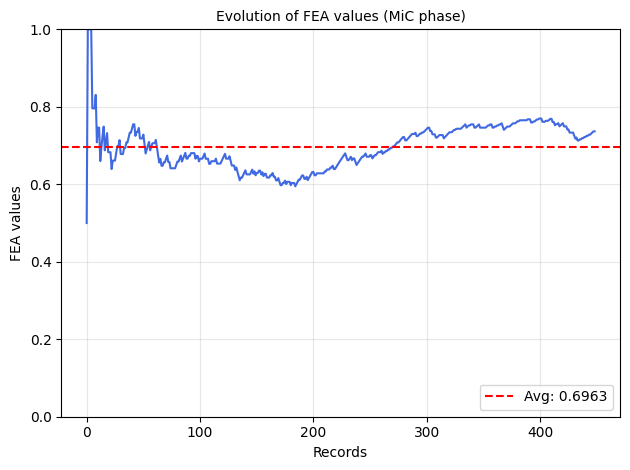

In [ ]:
plt.plot(acc_t_mic.fea_net, linestyle='-', color='royalblue')

avg_fea= np.mean(acc_t_mic.fea_net)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [ ]:
acc_t_mic.deferred_decisions


173

##### Two Stage Deferral

Optimal tau= 0.238983

In [ ]:
r_net_acc_t = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff=0.0)

r_net_acc_t.load_state_dict(torch.load(fr'r_nets/compas/iter_{mic_iter}/r_net_acc_t.pth'))
r_net_acc_t.to(device)
r_net_acc_t.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [ ]:
acc_t_strat_2= MiC(mic_net, 'Def_Net', 
               benchmark_performance= 65,
                 user_patience= 361,
                 performance_delta= 0.05,
                 belief_threshold= 0.7,
                 tau_threshold= 0.62,
                 anqi_mao_thresh=0.238983, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= mic_iter
 )



acc_t_df_2= acc_t_strat_2.start_MiC(X_stream, y_stream, acc_t_switch, r_net= r_net_acc_t, two_step_deferral=True)   #3 minutes

 33%|███▎      | 361/1085 [01:12<02:24,  5.00it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.7
Last 5 FEA values: [0.809428278664931, 0.801108495717019, 0.8031522509480723, 0.8051744475253216, 0.8071753242536637]


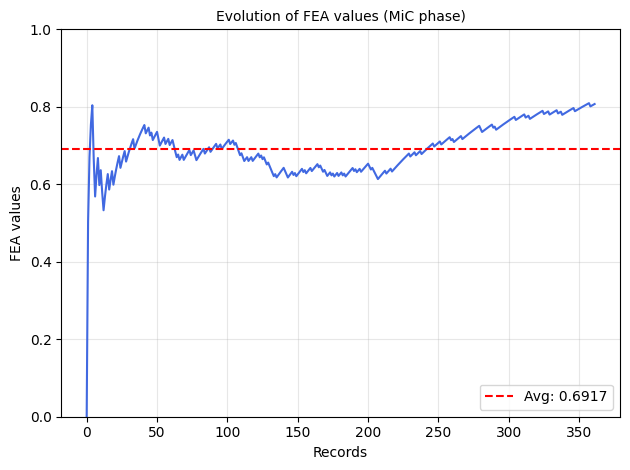

In [ ]:
plt.plot(acc_t_strat_2.fea_mic, linestyle='-', color='royalblue')
avg_fea_2= np.mean(acc_t_strat_2.fea_mic)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()



# sospetto che sia uguale no?

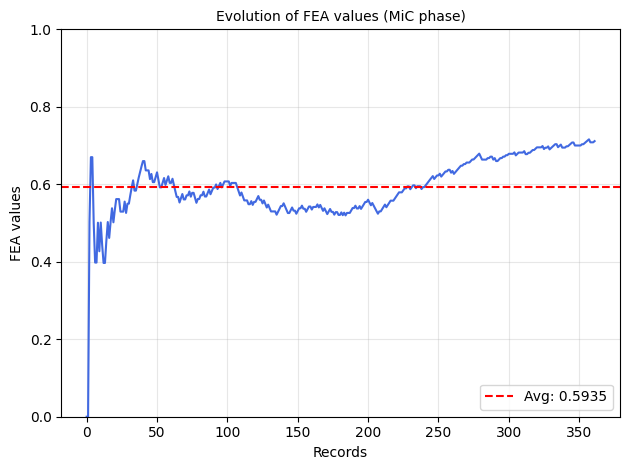

In [ ]:
plt.plot(acc_t_strat_2.fea_net, linestyle='-', color='royalblue')
avg_fea_2= np.mean(acc_t_strat_2.fea_net)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()



# sospetto che sia uguale no?

In [ ]:
print(acc_t_mic.mic_acc)
print(acc_t_mic.model_acc)
acc_t_mic.deferred_decisions

0.8017817371937639
0.6681514476614699


173

In [ ]:
print(acc_t_strat_2.mic_acc)
print(acc_t_strat_2.model_acc)
acc_t_strat_2.deferred_decisions


0.7292817679558011
0.6574585635359116


107

In [ ]:
acc_t_mic.deferred_decisions/len(acc_t_mic_df)


0.14773697694278395

In [ ]:
acc_t_strat_2.deferred_decisions/len(acc_t_df_2)

0.09870848708487084

In [ ]:
acc_t_mic.stats

{False: {'user': {'tried': 109, 'got': 109, 'conf': 1},
  'machine': {'tried': 295, 'got': 192, 'conf': 0}},
 True: {'user': {'tried': 64, 'got': 64, 'conf': 1},
  'machine': {'tried': 154, 'got': 84, 'conf': 0}}}

In [ ]:
acc_t_strat_2.stats

{False: {'user': {'tried': 74, 'got': 74, 'conf': 1},
  'machine': {'tried': 235, 'got': 143, 'conf': 0}},
 True: {'user': {'tried': 33, 'got': 33, 'conf': 1},
  'machine': {'tried': 127, 'got': 112, 'conf': 0}}}

#### Iter 2

##### HiC 

previous mean FEA was 0.6031874488111334

In [ ]:
#retrieving the trained model

# actually maybe i should train the baseline model again
file_path = r"HIC_res\compas\iter_1\results_accurate_trusting\HIC_DRIFT_User_accurate_trusting_ARFmodel.pkl"

with open(file_path, "rb") as f:
    prev_arf = pickle.load(f)

In [ ]:
clean_prepr = copy.deepcopy(prepr_transf)
hic_iter= 2
#arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['accurate_trusting']
name= f"{'accurate_trusting'}"
mod_name="ARF"



hic_inst= HiC(RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, mod_name, prev_arf,
                start_performance= 60.32,
                allocated_budget= 722,
                skepticism_threshold= 0.2,
                performance_delta= 0.05,
                dataset_name= 'compas',
                user_name= name,
                df_batch1=df_batch_1.iloc[722:], df_batch3=mic_data, batch1_test=test_batch_1, 
                target=target, 
                user_model=current_expert, 
                protected=protected, cats=categoricals, num=numericals,
                preprocessor=trained_preprocessor,
                training_iter= hic_iter 
                    )

In [ ]:
acc_t, _, equality, skept_count= hic_inst.start_HiC(df_avv)  


path= f".\processed_data\compas\hic_results_ds\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"hic_{name}.csv")

acc_t.to_csv(file_path, index=False)



 51%|█████     | 738/1445 [01:24<01:21,  8.72it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: HiC
Current desired perfomance: 63.336
Last 5 FEA values: [0.657644531794881, 0.6610705781907212, 0.6544551091876264, 0.6479058897302785, 0.6414222554335817]


In [ ]:
equality

[]

In [ ]:
skept_count #none overcame the skept threshold set at 0.3

123

In [ ]:
# retrieving the preprocessor
hic_iter= 2
prepr_path= fr"HIC_res\compas\iter_{hic_iter}\results_accurate_trusting\HIC_DRIFT_User_accurate_trusting_ARFpreprocessor.pkl"
trained_preprocessor = joblib.load(prepr_path)

df_batch_3= scale_df(mic_data, hic_inst.preprocessor, target)
df_batch_3= apply_order(df_batch_3)

df_calibration= scale_df(dfs['calibration'], hic_inst.preprocessor,target)
df_calibration= apply_order(df_calibration)


path= f".\processed_data\compas\calibration_datasets\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"acc_t_calibration.csv")

df_calibration.to_csv(file_path, index=False)


# applying scaler to calibration batch 3

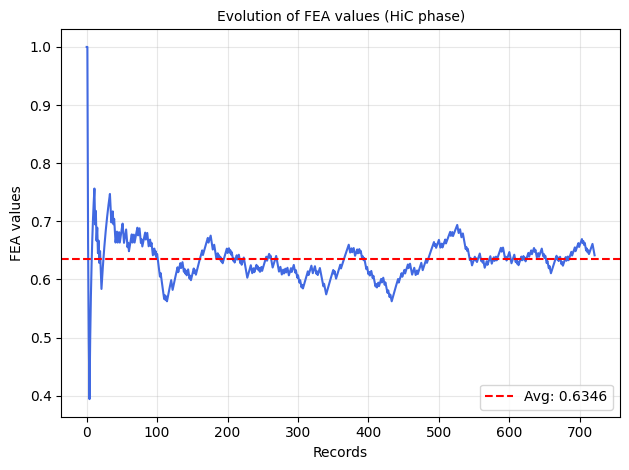

In [ ]:
plt.plot(hic_inst.machine_fea, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_inst.machine_fea)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.axhline(y= avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)  
plt.tight_layout()
plt.show()

# forgot to change the name again 

##### MiC Conf



In [ ]:
mic_iter= 2
acc_t_switch= pd.read_csv(fr".\processed_data\compas\switch_ds\iter_{mic_iter}\acc_t_switch.csv")

device = torch.device("cpu")
# prendo la struttura della mic 
mic_net = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=2, dropout_coeff= 0.2) 
mic_net.to(device)



DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [ ]:
X_stream= torch.tensor(data= df_batch_3.drop(columns=['did_recid']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['did_recid'].values, dtype= torch.long).to(device)


net_path= fr"nets\compas\iter_{mic_iter}\acc_t_models\32_16_acc_t_model_50.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Confidence based Deferral

Tau = 0.59

previous system FEA (mean): 0.7929


new user budget = 361 (prev) + 362

In [ ]:
acc_t_mic= MiC(mic_net, 'Def_Net', 
                benchmark_performance= 79.29,
                 user_patience= 723,
                 performance_delta= 0.05,
                 belief_threshold= 0.65,
                 tau_threshold= 0.59,
                 anqi_mao_thresh=None, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= 2
 )



acc_t_mic_df =acc_t_mic.start_MiC(X_stream, y_stream, acc_t_switch)   #3 minutes

 68%|██████▊   | 741/1085 [01:04<00:30, 11.41it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.65
Last 5 FEA values: [0.8366196076115636, 0.8282484319262082, 0.8299669596536291, 0.8216624484083977, 0.8234468538548426]


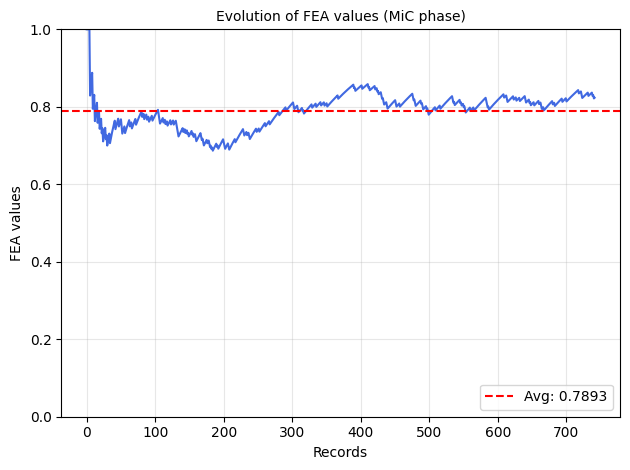

In [ ]:
plt.plot(acc_t_mic.fea_mic, linestyle='-', color='royalblue')

avg_fea= np.mean(acc_t_mic.fea_mic)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

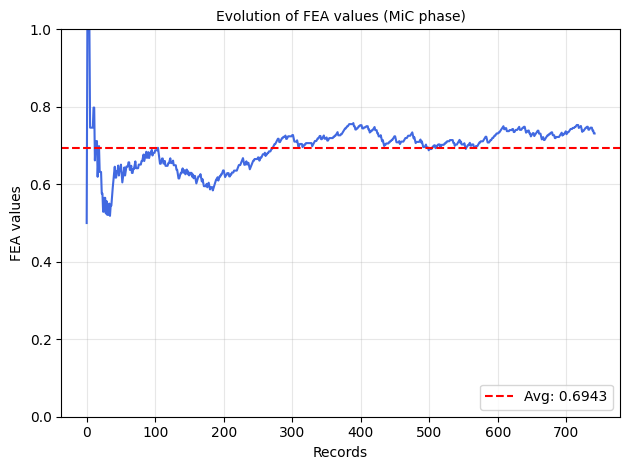

In [ ]:
plt.plot(acc_t_mic.fea_net, linestyle='-', color='royalblue')

avg_fea= np.mean(acc_t_mic.fea_net)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [ ]:
acc_t_mic.low_belief_count

724

##### Two Stage Deferral

Optimal tau= 0.344898

previous system FEA: 69.17

In [ ]:
r_net_acc_t = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff=0.0)

r_net_acc_t.load_state_dict(torch.load(fr"r_nets\compas\iter_{mic_iter}\r_net_acc_t.pth"))
r_net_acc_t.to(device)
r_net_acc_t.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [ ]:
acc_t_strat_2= MiC(mic_net, 'Def_Net', 
                benchmark_performance=69.17,
                 user_patience= 723,
                 performance_delta= 0.05,
                 belief_threshold= 0.65,
                 tau_threshold= 0.0,
                 anqi_mao_thresh= 0.344898, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= 2
 )



acc_t_df_2= acc_t_strat_2.start_MiC(X_stream, y_stream, acc_t_switch, r_net= r_net_acc_t, two_step_deferral=True)   #3 minutes

 67%|██████▋   | 725/1085 [01:03<00:31, 11.34it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.65
Last 5 FEA values: [0.7423903254172195, 0.7349612319938749, 0.737613454060128, 0.740239117376421, 0.7428384882579298]


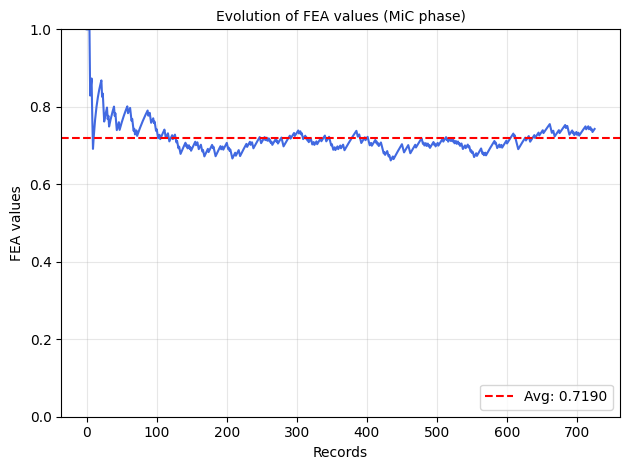

In [ ]:
plt.plot(acc_t_strat_2.fea_mic, linestyle='-', color='royalblue')
avg_fea_2= np.mean(acc_t_strat_2.fea_mic)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

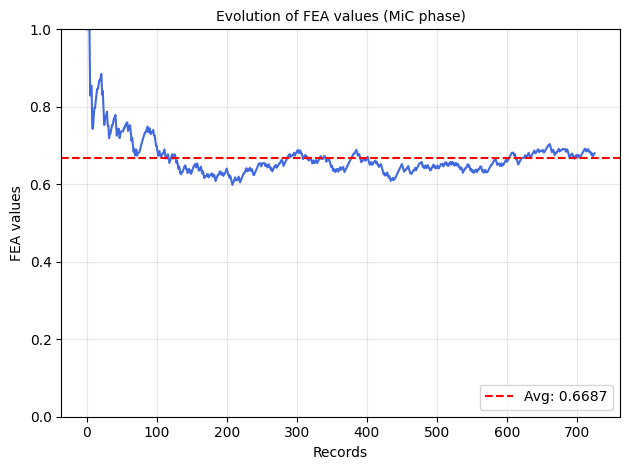

In [ ]:
plt.plot(acc_t_strat_2.fea_net, linestyle='-', color='royalblue')
avg_fea_2= np.mean(acc_t_strat_2.fea_net)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [ ]:
print(acc_t_mic.mic_acc)
print(acc_t_mic.model_acc)
acc_t_mic.deferred_decisions

0.7964959568733153
0.6522911051212938


301

In [ ]:
print(acc_t_strat_2.mic_acc)
print(acc_t_strat_2.model_acc)
acc_t_strat_2.deferred_decisions


0.7162534435261708
0.6528925619834711


150

In [ ]:
acc_t_mic.deferred_decisions/len(acc_t_mic_df)

0.20560109289617487

In [ ]:
acc_t_strat_2.deferred_decisions/len(acc_t_df_2)

0.10359116022099447

In [ ]:
acc_t_mic.stats

{False: {'user': {'tried': 184, 'got': 184, 'conf': 1},
  'machine': {'tried': 446, 'got': 287, 'conf': 0}},
 True: {'user': {'tried': 117, 'got': 117, 'conf': 1},
  'machine': {'tried': 296, 'got': 154, 'conf': 0}}}

In [ ]:
acc_t_strat_2.stats

{False: {'user': {'tried': 68, 'got': 68, 'conf': 1},
  'machine': {'tried': 439, 'got': 407, 'conf': 0}},
 True: {'user': {'tried': 82, 'got': 82, 'conf': 1},
  'machine': {'tried': 287, 'got': 169, 'conf': 0}}}

#### Iter 3

##### HiC 

previous mean FEA was 0.6346

In [ ]:
#retrieving the trained model

# actually maybe i should train the baseline model again
file_path = r"HIC_res\compas\iter_2\results_accurate_trusting\HIC_DRIFT_User_accurate_trusting_ARFmodel.pkl"

with open(file_path, "rb") as f:
    prev_arf = pickle.load(f)

In [ ]:

hic_iter= 3
#arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['accurate_trusting']
name= f"{'accurate_trusting'}"
mod_name="ARF"



hic_inst= HiC(RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, mod_name, prev_arf,
                start_performance= 63.46,
                allocated_budget= 723,
                skepticism_threshold= 0.2,
                performance_delta= 0.05,
                dataset_name= 'compas',
                user_name= name,
                df_batch1=df_batch_1.iloc[1444:], df_batch3=mic_data, batch1_test=test_batch_1, 
                target=target, 
                user_model=current_expert, 
                protected=protected, cats=categoricals, num=numericals,
                preprocessor=trained_preprocessor,
                training_iter= hic_iter 
                    )

In [ ]:
acc_t, _, equality, skept_count= hic_inst.start_HiC(df_avv)  


path= f".\processed_data\compas\hic_results_ds\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"hic_{name}.csv")

acc_t.to_csv(file_path, index=False)



100%|██████████| 723/723 [01:32<00:00,  7.81it/s]


In [ ]:
equality

[]

In [ ]:
skept_count #none overcame the skept threshold set at 0.3

175

In [ ]:
# retrieving the preprocessor

prepr_path= fr"HIC_res\compas\iter_3\results_accurate_trusting\User_accurate_trusting_ARFpreprocessor.pkl"
trained_preprocessor = joblib.load(prepr_path)

df_batch_3= scale_df(mic_data, hic_inst.preprocessor, target)
df_batch_3= apply_order(df_batch_3)

df_calibration= scale_df(dfs['calibration'], hic_inst.preprocessor,target)
df_calibration= apply_order(df_calibration)


path= f".\processed_data\compas\calibration_datasets\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"acc_t_calibration.csv")

df_calibration.to_csv(file_path, index=False)


# applying scaler to calibration batch 3

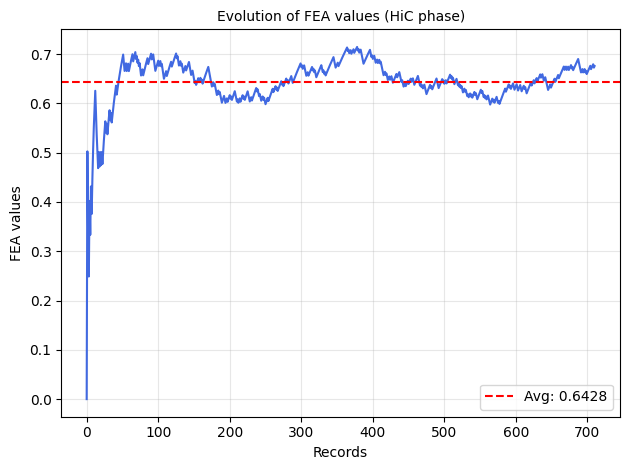

In [ ]:
plt.plot(hic_inst.machine_fea, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_inst.machine_fea)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.axhline(y= avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)  
plt.tight_layout()
plt.show()

# forgot to change the name again 

##### MiC Conf



In [ ]:
mic_iter= 3
acc_t_switch= pd.read_csv(fr".\processed_data\compas\switch_ds\iter_{mic_iter}\acc_t_switch.csv")

device = torch.device("cpu")
# prendo la struttura della mic 
mic_net = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=2, dropout_coeff= 0.2) 
mic_net.to(device)



DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [ ]:
X_stream= torch.tensor(data= df_batch_3.drop(columns=['did_recid']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['did_recid'].values, dtype= torch.long).to(device)


net_path= fr"nets\compas\iter_{mic_iter}\acc_t_models\32_16_acc_t_model_50.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Confidence based Deferral

Tau = 0.62

previous FEA: 0.7893


new user budget = 361 (prev) + 362

In [ ]:
acc_t_mic= MiC(mic_net, 'Def_Net', 
                benchmark_performance= 78.93,
                 user_patience= len(df_batch_3),
                 performance_delta= 0.05,
                 belief_threshold= 0.65,
                 tau_threshold= 0.62,
                 anqi_mao_thresh=None, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= 3
 )



acc_t_mic_df =acc_t_mic.start_MiC(X_stream, y_stream, acc_t_switch)   #3 minutes

100%|██████████| 1085/1085 [02:04<00:00,  8.70it/s]


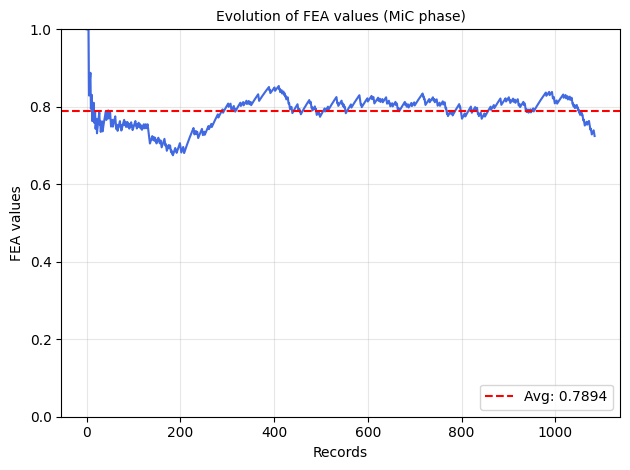

In [ ]:
plt.plot(acc_t_mic.fea_mic, linestyle='-', color='royalblue')

avg_fea= np.mean(acc_t_mic.fea_mic)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

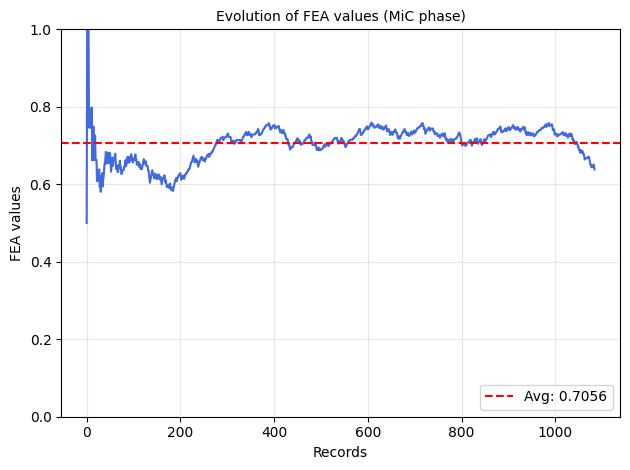

In [ ]:
plt.plot(acc_t_mic.fea_net, linestyle='-', color='royalblue')

avg_fea= np.mean(acc_t_mic.fea_net)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [ ]:
acc_t_mic.low_belief_count

977

##### Two Stage Deferral

Optimal tau= 0.364286

Deferral rate teorico = 33%

Previous FEA: 0.7190

In [ ]:
r_net_acc_t = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff=0.0)

r_net_acc_t.load_state_dict(torch.load(fr"r_nets\compas\iter_{mic_iter}\r_net_acc_t.pth"))
r_net_acc_t.to(device)
r_net_acc_t.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [ ]:
acc_t_strat_3= MiC(mic_net, 'Def_Net', 
                benchmark_performance= 71.90,
                 user_patience= len(df_batch_3),
                 performance_delta= 0.05,
                 belief_threshold= 0.65,
                 tau_threshold= 0.0,
                 anqi_mao_thresh= 0.371429, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= 3
 )



acc_t_df_3= acc_t_strat_3.start_MiC(X_stream, y_stream, acc_t_switch, r_net= r_net_acc_t, two_step_deferral=True)   #3 minutes

100%|██████████| 1085/1085 [01:49<00:00,  9.92it/s]


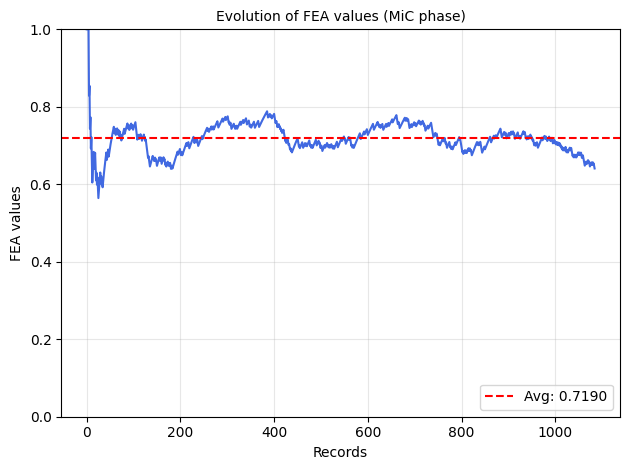

In [ ]:
plt.plot(acc_t_strat_3.fea_mic, linestyle='-', color='royalblue')
avg_fea_2= np.mean(acc_t_strat_2.fea_mic)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

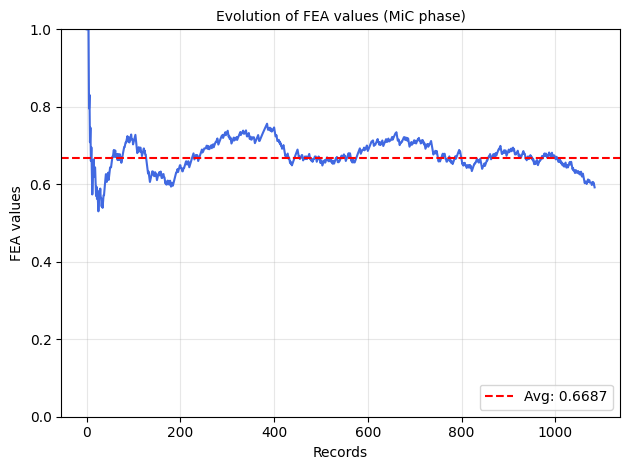

In [ ]:
plt.plot(acc_t_strat_3.fea_net, linestyle='-', color='royalblue')
avg_fea_2= np.mean(acc_t_strat_2.fea_net)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [ ]:
print(acc_t_mic.mic_acc)
print(acc_t_mic.model_acc)
acc_t_mic.deferred_decisions

0.7852534562211981
0.6442396313364055


409

In [ ]:
print(acc_t_strat_3.mic_acc)
print(acc_t_strat_3.model_acc)
acc_t_strat_3.deferred_decisions


0.7115207373271889
0.6442396313364055


156

In [ ]:
acc_t_mic.deferred_decisions /len(acc_t_mic_df)

0.227728285077951

In [ ]:
acc_t_strat_3.deferred_decisions/len(acc_t_df_2)

0.10773480662983426

In [ ]:
acc_t_mic.stats

{False: {'user': {'tried': 244, 'got': 244, 'conf': 1},
  'machine': {'tried': 624, 'got': 413, 'conf': 0}},
 True: {'user': {'tried': 165, 'got': 165, 'conf': 1},
  'machine': {'tried': 461, 'got': 263, 'conf': 0}}}

In [ ]:
acc_t_strat_3.stats

{False: {'user': {'tried': 78, 'got': 78, 'conf': 1},
  'machine': {'tried': 624, 'got': 603, 'conf': 0}},
 True: {'user': {'tried': 78, 'got': 78, 'conf': 1},
  'machine': {'tried': 461, 'got': 326, 'conf': 0}}}

### Expert: Inaccurate, Trusting 

#### Iter 1

##### HiC, 722 record batch

In [ ]:
# defining necessary instantiation params for HiC class
hic_iter= 1

clean_prepr = copy.deepcopy(prepr_transf)
arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['inaccurate_trusting']
name= "inaccurate_trusting"
mod_name="ARF"


hic_inst= HiC(RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, 
                mod_name, arf_mod,
                start_performance= 65,
                allocated_budget= 722,
                skepticism_threshold= 0.2,
                performance_delta= 0.05,
                dataset_name= 'compas',
                user_name= name,
                df_batch1=df_batch_1, df_batch3=mic_data, batch1_test=test_batch_1, 
                target=target, 
                user_model=current_expert, 
                protected=protected, cats=categoricals, num=numericals,
                preprocessor=prepr_transf,
                training_iter= hic_iter 
                    )

In [ ]:
inacc_t, _, equality, skept_count= hic_inst.start_HiC(df_avv)  

# saving the results in their folder 
path= f".\processed_data\compas\hic_results_ds\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"hic_{name}.csv")

inacc_t.to_csv(file_path, index=False)

 34%|███▍      | 733/2167 [01:20<02:37,  9.12it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: HiC
Current desired perfomance: 68.25
Last 5 FEA values: [0.6435400422408887, 0.6471072361868323, 0.6506387065281865, 0.6541348115302392, 0.6575959058551104]


In [ ]:
equality

[]

In [ ]:
skept_count #none overcame the skept threshold set at 0.6

136

Applying learned scaler to the calibration and mic batches

In [ ]:
# retrieving the preprocessor
prepr_path= fr"HIC_res\compas\iter_{hic_iter}\results_inaccurate_trusting\HIC_DRIFT_User_inaccurate_trusting_ARFpreprocessor.pkl"
trained_preprocessor = joblib.load(prepr_path)

df_batch_3= scale_df(mic_data, trained_preprocessor, target)
df_batch_3= apply_order(df_batch_3)

df_calibration= scale_df(dfs['calibration'], trained_preprocessor,target)
df_calibration= apply_order(df_calibration)


path= f".\processed_data\compas\calibration_datasets\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"inacc_t_calibration.csv")

df_calibration.to_csv(file_path, index=False)


# applying scaler to calibration batch 3

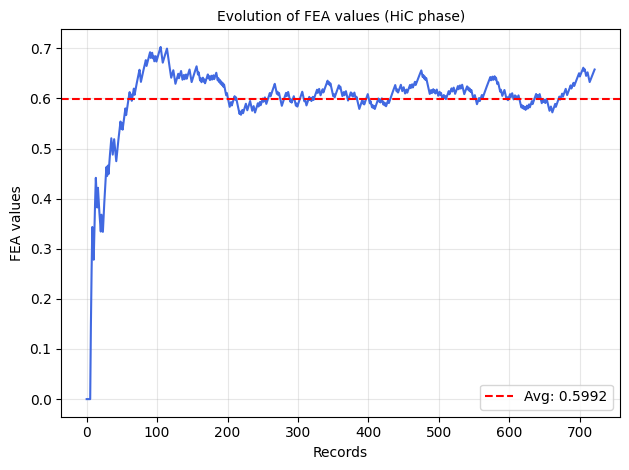

In [ ]:
plt.plot(hic_inst.machine_fea, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_inst.machine_fea)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.axhline(y= avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)  
plt.tight_layout()
plt.show()

# forgot to change the name again 

##### MiC

In [ ]:
mic_iter= 1

inacc_t_switch= pd.read_csv(fr".\processed_data\compas\switch_ds\iter_{mic_iter}\inacc_t_switch.csv")

device = torch.device("cpu")
# prendo la struttura della mic 
mic_net = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=2, dropout_coeff= 0.0) #tanto va in eval non serve il dropout
mic_net.to(device)


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [ ]:
X_stream= torch.tensor(data= df_batch_3.drop(columns=['did_recid']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['did_recid'].values, dtype= torch.long).to(device)


net_path= fr".\nets\compas\iter_{mic_iter}\inacc_t_models\32_16_inacc_t_model_50.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Confidence based Deferral

Tau = 0.56

batches: 361, 362, 362 rec

In [ ]:
inacc_t_mic= MiC(mic_net, 'Def_Net', 
               benchmark_performance= 65, #nel primo run è irrilevante
                 user_patience= 361,
                 performance_delta= 0.05,
                 belief_threshold= 0.6,
                 tau_threshold= 0.56,
                 anqi_mao_thresh=None, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= mic_iter
 )



inacc_t_mic_df =inacc_t_mic.start_MiC(X_stream, y_stream, inacc_t_switch)   #3 minutes

 33%|███▎      | 363/1085 [00:52<01:45,  6.86it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.6
Last 5 FEA values: [0.7177570885624909, 0.7206565408153651, 0.7235254243863214, 0.7263640775504099, 0.729172834512599]


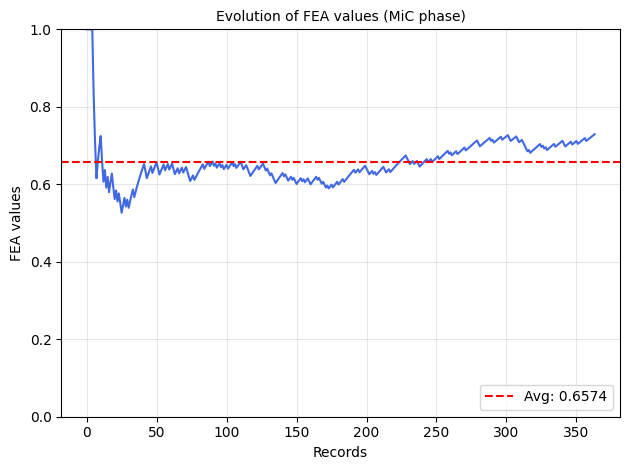

In [ ]:
plt.plot(inacc_t_mic.fea_mic, linestyle='-', color='royalblue')

avg_fea= np.mean(inacc_t_mic.fea_mic)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

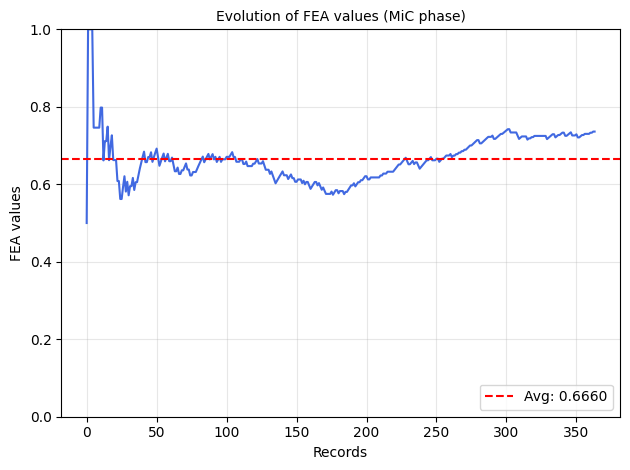

In [ ]:
plt.plot(inacc_t_mic.fea_net, linestyle='-', color='royalblue')

avg_fea= np.mean(inacc_t_mic.fea_net)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

##### Two Stage Deferral

Optimal tau= 0.311864

In [ ]:
r_net_inacc_t = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff=0.0)

r_net_inacc_t.load_state_dict(torch.load(fr'r_nets/compas/iter_{mic_iter}/r_net_inacc_t.pth'))
r_net_inacc_t.to(device)
r_net_inacc_t.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [ ]:
inacc_t_strat_2= MiC(mic_net, 'Def_Net', 
               benchmark_performance= 65,
                 user_patience= 361,
                 performance_delta= 0.05,
                 belief_threshold= 0.7,
                 tau_threshold= 0.56,
                 anqi_mao_thresh=0.311864, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= mic_iter
 )



inacc_t_df_2= inacc_t_strat_2.start_MiC(X_stream, y_stream, inacc_t_switch, r_net= r_net_inacc_t, two_step_deferral=True)   #3 minutes

 33%|███▎      | 361/1085 [00:49<01:39,  7.30it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.7
Last 5 FEA values: [0.6965963778701257, 0.6894363479836727, 0.6926276159600078, 0.6855123240603109, 0.688742142039243]


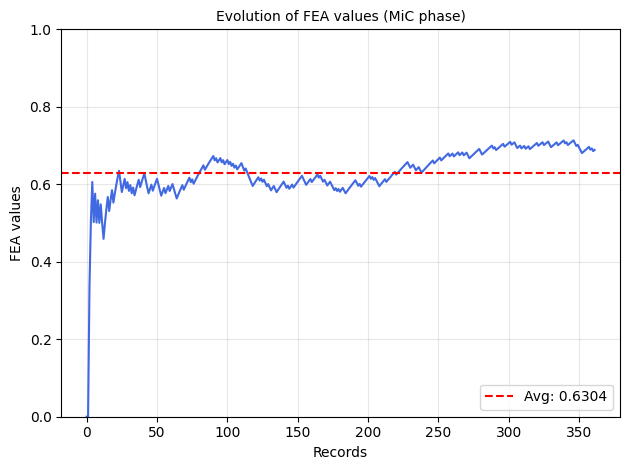

In [ ]:
plt.plot(inacc_t_strat_2.fea_mic, linestyle='-', color='royalblue')
avg_fea_2= np.mean(inacc_t_strat_2.fea_mic)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()



# sospetto che sia uguale no?

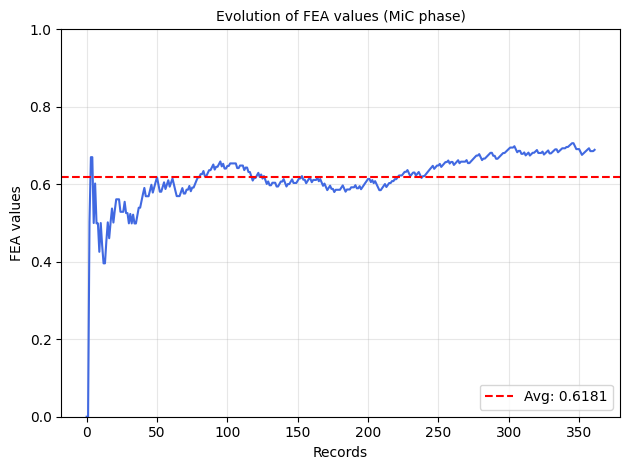

In [ ]:
plt.plot(inacc_t_strat_2.fea_net, linestyle='-', color='royalblue')
avg_fea_2= np.mean(inacc_t_strat_2.fea_net)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()



# sospetto che sia uguale no?

In [ ]:
print(inacc_t_mic.mic_acc)
print(inacc_t_mic.model_acc)
inacc_t_mic.deferred_decisions

0.6785714285714286
0.6730769230769231


127

In [ ]:
print(inacc_t_strat_2.mic_acc)
print(inacc_t_strat_2.model_acc)
inacc_t_strat_2.deferred_decisions


0.6574585635359116
0.6712707182320442


98

In [ ]:
inacc_t_mic.deferred_decisions/len(inacc_t_mic_df)


0.11694290976058933

In [ ]:
inacc_t_strat_2.deferred_decisions/len(inacc_t_df_2)

0.09040590405904059

In [ ]:
inacc_t_mic.stats

{False: {'user': {'tried': 71, 'got': 71, 'conf': 1},
  'machine': {'tried': 222, 'got': 151, 'conf': 0}},
 True: {'user': {'tried': 56, 'got': 56, 'conf': 1},
  'machine': {'tried': 142, 'got': 86, 'conf': 0}}}

In [ ]:
inacc_t_strat_2.stats

{False: {'user': {'tried': 60, 'got': 60, 'conf': 1},
  'machine': {'tried': 220, 'got': 131, 'conf': 0}},
 True: {'user': {'tried': 38, 'got': 38, 'conf': 1},
  'machine': {'tried': 142, 'got': 133, 'conf': 0}}}

#### Iter 2

##### HiC 

previous mean FEA was 0.5992

In [ ]:
#retrieving the trained model

# actually maybe i should train the baseline model again
file_path = r"HIC_res\compas\iter_1\results_inaccurate_trusting\HIC_DRIFT_User_inaccurate_trusting_ARFmodel.pkl"

with open(file_path, "rb") as f:
    prev_arf = pickle.load(f)

In [ ]:
path= fr"HIC_res\compas\iter_1\results_inaccurate_trusting\HIC_DRIFT_User_inaccurate_trusting_ARFpreprocessor.pkl"
previous_preprocessor = joblib.load(path)

hic_iter= 2

current_expert= experts_obj['inaccurate_trusting']
name= 'inaccurate_trusting'
mod_name="ARF"



hic_inst= HiC(RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, mod_name, prev_arf,
                start_performance= 59.92,
                allocated_budget= 722,
                skepticism_threshold= 0.2,
                performance_delta= 0.05,
                dataset_name= 'compas',
                user_name= name,
                df_batch1=df_batch_1.iloc[722:], df_batch3=mic_data, batch1_test=test_batch_1, 
                target=target, 
                user_model=current_expert, 
                protected=protected, cats=categoricals, num=numericals,
                preprocessor=previous_preprocessor,
                training_iter= hic_iter 
                    )

In [ ]:
inacc_t, _, equality, skept_count= hic_inst.start_HiC(df_avv)  


path= f".\processed_data\compas\hic_results_ds\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"hic_{name}.csv")

inacc_t.to_csv(file_path, index=False)



 51%|█████     | 738/1445 [01:21<01:18,  9.03it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: HiC
Current desired perfomance: 62.916000000000004
Last 5 FEA values: [0.6403426968008064, 0.6439418874719043, 0.6374978287935951, 0.641125436309629, 0.6347096544295288]


In [ ]:
equality

[]

In [ ]:
skept_count #none overcame the skept threshold set at 0.3

255

In [ ]:
# retrieving the preprocessor

prepr_path= fr"HIC_res\compas\iter_{hic_iter}\results_inaccurate_trusting\HIC_DRIFT_User_inaccurate_trusting_ARFpreprocessor.pkl"
trained_preprocessor = joblib.load(prepr_path)

df_batch_3= scale_df(mic_data, trained_preprocessor, target)
df_batch_3= apply_order(df_batch_3)

df_calibration= scale_df(dfs['calibration'], trained_preprocessor,target)
df_calibration= apply_order(df_calibration)


path= f".\processed_data\compas\calibration_datasets\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"inacc_t_calibration.csv")

df_calibration.to_csv(file_path, index=False)


# applying scaler to calibration batch 3

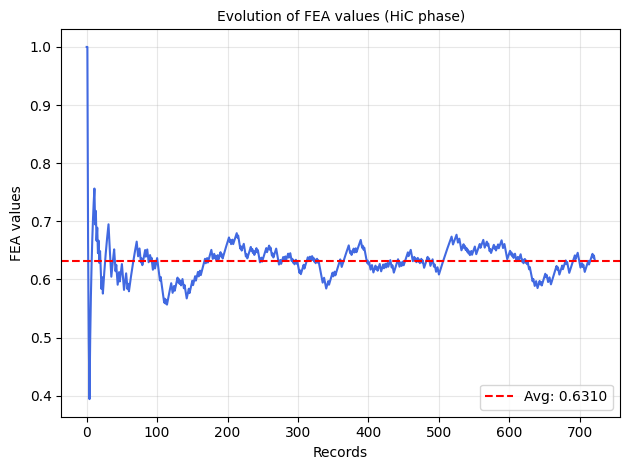

In [ ]:
plt.plot(hic_inst.machine_fea, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_inst.machine_fea)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.axhline(y= avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)  
plt.tight_layout()
plt.show()

# forgot to change the name again 

##### MiC Conf



In [ ]:
mic_iter= 2
inacc_t_switch= pd.read_csv(fr".\processed_data\compas\switch_ds\iter_{mic_iter}\inacc_t_switch.csv")

device = torch.device("cpu")
# prendo la struttura della mic 
mic_net = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=2, dropout_coeff= 0.2) 
mic_net.to(device)



DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [ ]:
X_stream= torch.tensor(data= df_batch_3.drop(columns=['did_recid']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['did_recid'].values, dtype= torch.long).to(device)


net_path= fr"nets\compas\iter_{mic_iter}\inacc_t_models\32_16_inacc_t_model_46.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Confidence based Deferral

Tau = 0.63

previous system FEA (mean): 65.74


new user budget = 361 (prev) + 362

In [ ]:
inacc_t_mic= MiC(mic_net, 'Def_Net', 
                benchmark_performance= 65.74,
                 user_patience= 723,
                 performance_delta= 0.05,
                 belief_threshold= 0.65,
                 tau_threshold= 0.63,
                 anqi_mao_thresh=None, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= 2
 )



inacc_t_mic_df =inacc_t_mic.start_MiC(X_stream, y_stream, inacc_t_switch)   #3 minutes

 67%|██████▋   | 723/1085 [01:00<00:30, 11.96it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.65
Last 5 FEA values: [0.7705252212703423, 0.7728216059493349, 0.7750949941843894, 0.7673386254298176, 0.7696668494713117]


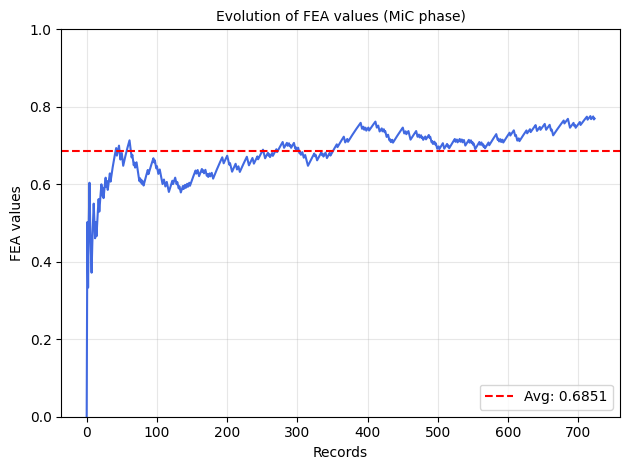

In [ ]:
plt.plot(inacc_t_mic.fea_mic, linestyle='-', color='royalblue')

avg_fea= np.mean(inacc_t_mic.fea_mic)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

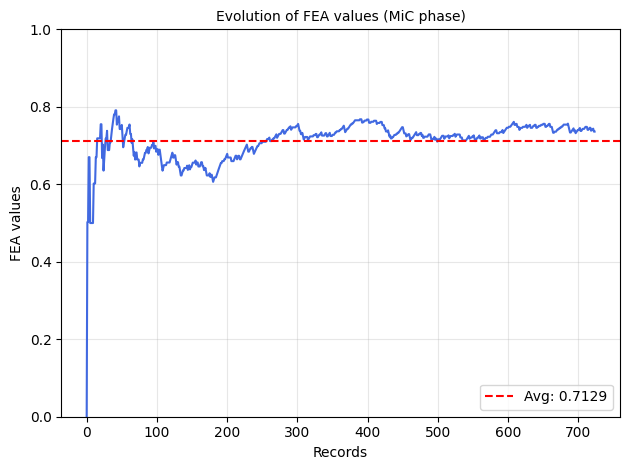

In [ ]:
plt.plot(inacc_t_mic.fea_net, linestyle='-', color='royalblue')

avg_fea= np.mean(inacc_t_mic.fea_net)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [ ]:
inacc_t_mic.low_belief_count

724

##### Two Stage Deferral

Optimal tau= 0.412245

previous system FEA: 63.04

In [ ]:
r_net_inacc_t = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff=0.0)

r_net_inacc_t.load_state_dict(torch.load(fr"r_nets\compas\iter_{mic_iter}\r_net_inacc_t.pth"))
r_net_inacc_t.to(device)
r_net_inacc_t.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [ ]:
inacc_t_strat_2= MiC(mic_net, 'Def_Net', 
                benchmark_performance=63.04,
                 user_patience= 723,
                 performance_delta= 0.05,
                 belief_threshold= 0.65,
                 tau_threshold= 0.0,
                 anqi_mao_thresh= 0.412245, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= 2
 )



inacc_t_df_2= inacc_t_strat_2.start_MiC(X_stream, y_stream, inacc_t_switch, r_net= r_net_inacc_t, two_step_deferral=True)   #3 minutes

 67%|██████▋   | 723/1085 [01:01<00:30, 11.80it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.65
Last 5 FEA values: [0.6979062404534856, 0.6909221997374523, 0.694015160394075, 0.687070156819456, 0.6902016211011396]


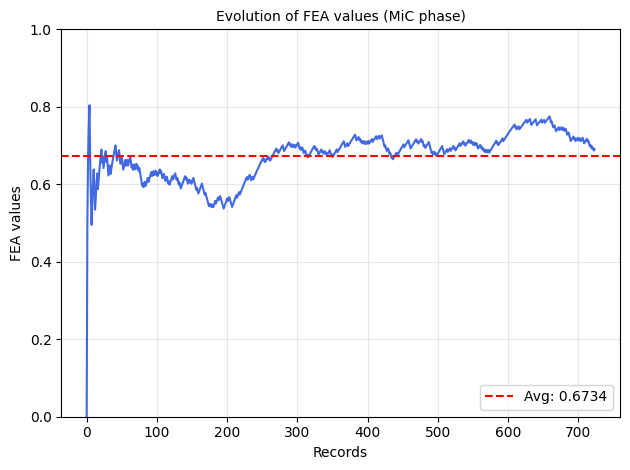

In [ ]:
plt.plot(inacc_t_strat_2.fea_mic, linestyle='-', color='royalblue')
avg_fea_2= np.mean(inacc_t_strat_2.fea_mic)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

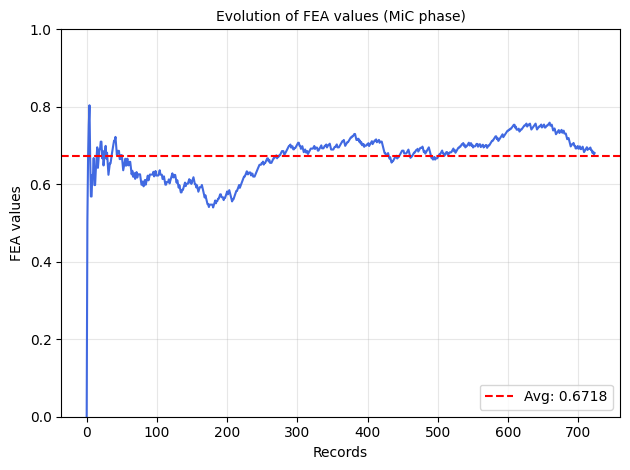

In [ ]:
plt.plot(inacc_t_strat_2.fea_net, linestyle='-', color='royalblue')
avg_fea_2= np.mean(inacc_t_strat_2.fea_net)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [ ]:
print(inacc_t_mic.mic_acc)
print(inacc_t_mic.model_acc)
inacc_t_mic.deferred_decisions

0.7071823204419889
0.6588397790055248


301

In [ ]:
print(inacc_t_strat_2.mic_acc)
print(inacc_t_strat_2.model_acc)
inacc_t_strat_2.deferred_decisions


0.6823204419889503
0.6588397790055248


172

In [ ]:
inacc_t_mic.deferred_decisions/len(inacc_t_mic_df)

0.20816044260027664

In [ ]:
inacc_t_strat_2.deferred_decisions/len(inacc_t_df_2)

0.11894882434301521

In [ ]:
inacc_t_mic.stats

{False: {'user': {'tried': 158, 'got': 158, 'conf': 1},
  'machine': {'tried': 548, 'got': 367, 'conf': 0}},
 True: {'user': {'tried': 143, 'got': 143, 'conf': 1},
  'machine': {'tried': 176, 'got': 56, 'conf': 0}}}

In [ ]:
inacc_t_strat_2.stats

{False: {'user': {'tried': 73, 'got': 73, 'conf': 1},
  'machine': {'tried': 548, 'got': 448, 'conf': 0}},
 True: {'user': {'tried': 99, 'got': 99, 'conf': 1},
  'machine': {'tried': 176, 'got': 104, 'conf': 0}}}

#### Iter 3

##### HiC 

previous mean FEA was 63.10

In [ ]:
#retrieving the trained model

# actually maybe i should train the baseline model again
file_path = r"HIC_res\compas\iter_2\results_inaccurate_trusting\HIC_DRIFT_User_inaccurate_trusting_ARFmodel.pkl"

with open(file_path, "rb") as f:
    prev_arf = pickle.load(f)

In [ ]:
hic_iter= 3
path= fr"HIC_res\compas\iter_2\results_inaccurate_trusting\HIC_DRIFT_User_inaccurate_trusting_ARFpreprocessor.pkl"
previous_preprocessor = joblib.load(path)


current_expert= experts_obj['inaccurate_trusting']
name= f"{'inaccurate_trusting'}"
mod_name="ARF"



hic_inst= HiC(RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, mod_name, prev_arf,
                start_performance= 63.10,
                allocated_budget= 723,
                skepticism_threshold= 0.2,
                performance_delta= 0.05,
                dataset_name= 'compas',
                user_name= name,
                df_batch1=df_batch_1.iloc[1444:], df_batch3=mic_data, batch1_test=test_batch_1, 
                target=target, 
                user_model=current_expert, 
                protected=protected, cats=categoricals, num=numericals,
                preprocessor=previous_preprocessor,
                training_iter= hic_iter 
                    )

In [ ]:
inacc_t, _, equality, skept_count= hic_inst.start_HiC(df_avv)  


path= f".\processed_data\compas\hic_results_ds\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"hic_{name}.csv")

inacc_t.to_csv(file_path, index=False)



100%|██████████| 723/723 [01:23<00:00,  8.69it/s]


In [ ]:
equality

[]

In [ ]:
skept_count #none overcame the skept threshold set at 0.3

280

In [ ]:
# retrieving the preprocessor

prepr_path= fr"HIC_res\compas\iter_3\results_inaccurate_trusting\User_inaccurate_trusting_ARFpreprocessor.pkl"
trained_preprocessor = joblib.load(prepr_path)

df_batch_3= scale_df(mic_data, trained_preprocessor, target)
df_batch_3= apply_order(df_batch_3)

df_calibration= scale_df(dfs['calibration'],trained_preprocessor,target)
df_calibration= apply_order(df_calibration)


path= f".\processed_data\compas\calibration_datasets\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"inacc_t_calibration.csv")

df_calibration.to_csv(file_path, index=False)


# applying scaler to calibration batch 3

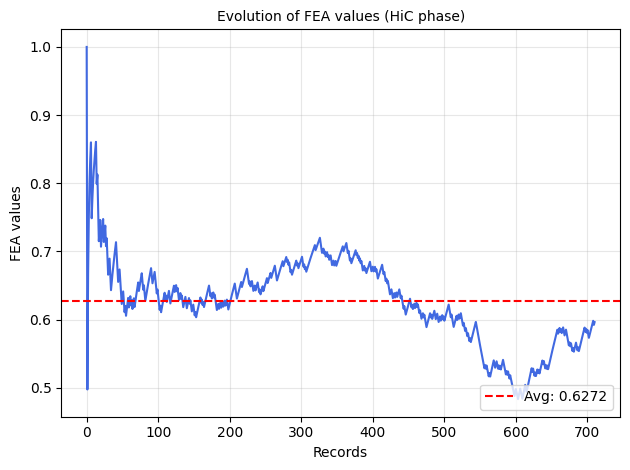

In [ ]:
plt.plot(hic_inst.machine_fea, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_inst.machine_fea)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.axhline(y= avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)  
plt.tight_layout()
plt.show()

# forgot to change the name again 

##### MiC Conf



In [ ]:
mic_iter= 3
inacc_t_switch= pd.read_csv(fr".\processed_data\compas\switch_ds\iter_{mic_iter}\inacc_t_switch.csv")

device = torch.device("cpu")
# prendo la struttura della mic 
mic_net = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=2, dropout_coeff= 0.2) 
mic_net.to(device)


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [ ]:
X_stream= torch.tensor(data= df_batch_3.drop(columns=['did_recid']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['did_recid'].values, dtype= torch.long).to(device)


net_path= fr"nets\compas\iter_{mic_iter}\inacc_t_models\32_16_inacc_t_model_49.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Confidence based Deferral

Tau = 0.61

previous FEA: 0.6851


new user budget = 361 (prev) + 362

In [ ]:
inacc_t_mic= MiC(mic_net, 'Def_Net', 
                benchmark_performance= 68.51,
                 user_patience= len(df_batch_3),
                 performance_delta= 0.05,
                 belief_threshold= 0.65,
                 tau_threshold= 0.61,
                 anqi_mao_thresh=None, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= 3
 )



inacc_t_mic_df =inacc_t_mic.start_MiC(X_stream, y_stream, inacc_t_switch)   #3 minutes

100%|██████████| 1085/1085 [01:32<00:00, 11.73it/s]


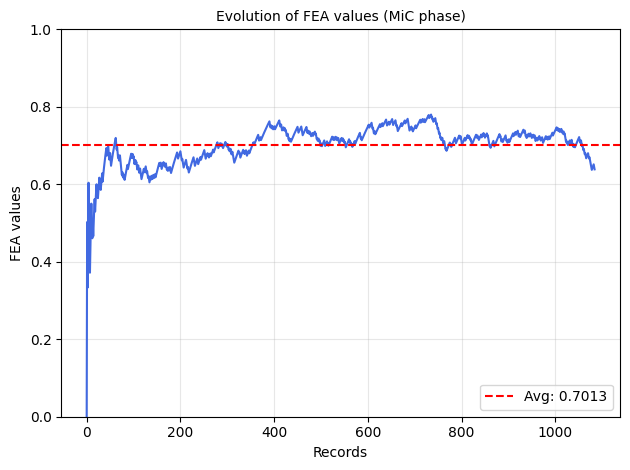

In [ ]:
plt.plot(inacc_t_mic.fea_mic, linestyle='-', color='royalblue')

avg_fea= np.mean(inacc_t_mic.fea_mic)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

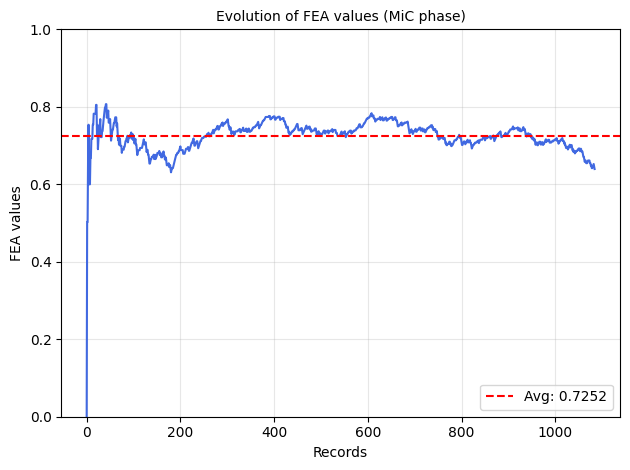

In [ ]:
plt.plot(inacc_t_mic.fea_net, linestyle='-', color='royalblue')

avg_fea= np.mean(inacc_t_mic.fea_net)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [ ]:
inacc_t_mic.low_belief_count

1085

##### Two Stage Deferral

Optimal tau= 0.444898

Previous FEA: 0.6734

In [ ]:
r_net_inacc_t = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff=0.0)

r_net_inacc_t.load_state_dict(torch.load(fr"r_nets\compas\iter_{mic_iter}\r_net_inacc_t.pth"))
r_net_inacc_t.to(device)
r_net_inacc_t.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [ ]:
inacc_t_strat_3= MiC(mic_net, 'Def_Net', 
                benchmark_performance= 67.34,
                 user_patience= len(df_batch_3),
                 performance_delta= 0.05,
                 belief_threshold= 0.65,
                 tau_threshold= 0.0,
                 anqi_mao_thresh= 0.444898, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= 3
 )



inacc_t_df_3= inacc_t_strat_3.start_MiC(X_stream, y_stream, inacc_t_switch, r_net= r_net_inacc_t, two_step_deferral=True)   #3 minutes

100%|██████████| 1085/1085 [01:30<00:00, 12.00it/s]


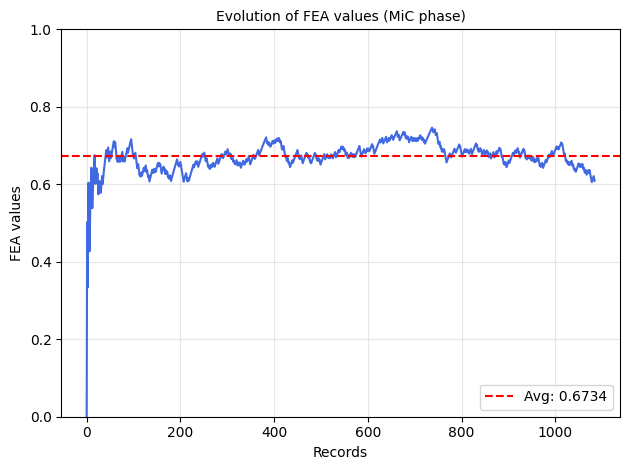

In [ ]:
plt.plot(inacc_t_strat_3.fea_mic, linestyle='-', color='royalblue')
avg_fea_2= np.mean(inacc_t_strat_2.fea_mic)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

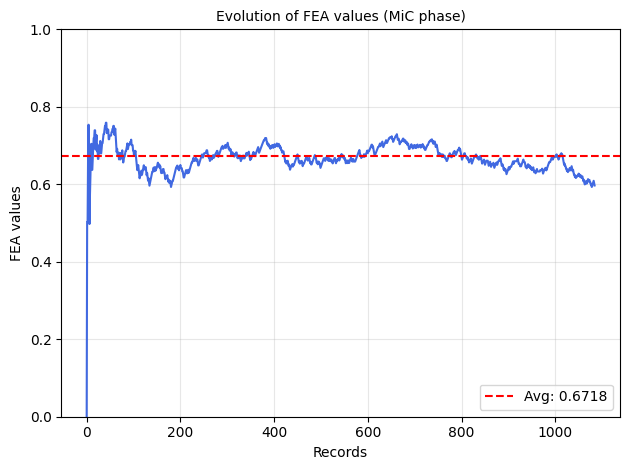

In [ ]:
plt.plot(inacc_t_strat_3.fea_net, linestyle='-', color='royalblue')
avg_fea_2= np.mean(inacc_t_strat_2.fea_net)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [ ]:
print(inacc_t_mic.mic_acc)
print(inacc_t_mic.model_acc)
inacc_t_mic.deferred_decisions

0.7032258064516129
0.6497695852534562


445

In [ ]:
print(inacc_t_strat_3.mic_acc)
print(inacc_t_strat_3.model_acc)
inacc_t_strat_3.deferred_decisions


0.6691244239631337
0.6497695852534562


229

In [ ]:
inacc_t_mic.deferred_decisions /len(inacc_t_mic_df)

0.2477728285077951

In [ ]:
inacc_t_strat_3.deferred_decisions/len(inacc_t_df_3)

0.12750556792873052

In [ ]:
inacc_t_mic.stats

{False: {'user': {'tried': 233, 'got': 233, 'conf': 1},
  'machine': {'tried': 820, 'got': 559, 'conf': 0}},
 True: {'user': {'tried': 212, 'got': 212, 'conf': 1},
  'machine': {'tried': 265, 'got': 81, 'conf': 0}}}

In [ ]:
inacc_t_strat_3.stats

{False: {'user': {'tried': 96, 'got': 96, 'conf': 1},
  'machine': {'tried': 820, 'got': 727, 'conf': 0}},
 True: {'user': {'tried': 133, 'got': 133, 'conf': 1},
  'machine': {'tried': 265, 'got': 129, 'conf': 0}}}

### Expert: Accurate, Not Trusting 

#### Iter 1

##### HiC, 722 record batch

In [ ]:
# defining necessary instantiation params for HiC class
hic_iter= 1

clean_prepr = copy.deepcopy(prepr_transf)
arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['accurate_not_trusting']
name= "accurate_not_trusting"
mod_name="ARF"


hic_inst= HiC(RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, 
                mod_name, arf_mod,
                start_performance= 65,
                allocated_budget= 722,
                skepticism_threshold= 0.2,
                performance_delta= 0.05,
                dataset_name= 'compas',
                user_name= name,
                df_batch1=df_batch_1, df_batch3=mic_data, batch1_test=test_batch_1, 
                target=target, 
                user_model=current_expert, 
                protected=protected, cats=categoricals, num=numericals,
                preprocessor=prepr_transf,
                training_iter= hic_iter 
                    )

In [ ]:
acc_nt, _, equality, skept_count= hic_inst.start_HiC(df_avv)  

# saving the results in their folder 
path= f".\processed_data\compas\hic_results_ds\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"hic_{name}.csv")

acc_nt.to_csv(file_path, index=False)

 34%|███▍      | 735/2167 [01:53<03:41,  6.48it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: HiC
Current desired perfomance: 68.25
Last 5 FEA values: [0.6315932886883315, 0.6352800371200419, 0.6389298646707487, 0.6425431416129991, 0.6461202344954118]


In [ ]:
equality

[]

In [ ]:
skept_count #none overcame the skept threshold set at 0.6

46

Applying learned scaler to the calibration and mic batches

In [ ]:
# retrieving the preprocessor

prepr_path= fr"HIC_res\compas\iter_{hic_iter}\results_accurate_not_trusting\HIC_DRIFT_User_accurate_not_trusting_ARFpreprocessor.pkl"
trained_preprocessor = joblib.load(prepr_path)

df_batch_3= scale_df(mic_data, trained_preprocessor, target)
df_batch_3= apply_order(df_batch_3)

df_calibration= scale_df(dfs['calibration'], trained_preprocessor,target)
df_calibration= apply_order(df_calibration)


path= f".\processed_data\compas\calibration_datasets\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"acc_nt_calibration.csv")

df_calibration.to_csv(file_path, index=False)


# applying scaler to calibration batch 3

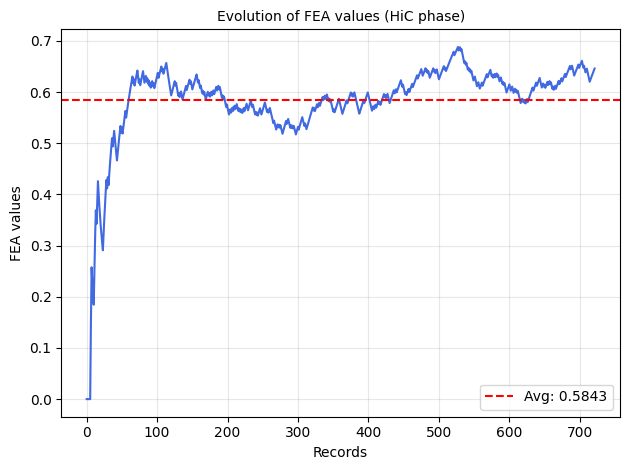

In [ ]:
plt.plot(hic_inst.machine_fea, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_inst.machine_fea)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.axhline(y= avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)  
plt.tight_layout()
plt.show()

# forgot to change the name again 

##### MiC

In [ ]:
mic_iter= 1

acc_nt_switch= pd.read_csv(fr".\processed_data\compas\switch_ds\iter_{mic_iter}\acc_nt_switch.csv")

device = torch.device("cpu")
# prendo la struttura della mic 
mic_net = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=2, dropout_coeff= 0.0) #tanto va in eval non serve il dropout
mic_net.to(device)


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [ ]:
X_stream= torch.tensor(data= df_batch_3.drop(columns=['did_recid']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['did_recid'].values, dtype= torch.long).to(device)


net_path= fr".\nets\compas\iter_{mic_iter}\acc_nt_models\32_16_acc_nt_model_37.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Confidence based Deferral

Tau = 0.62

batches: 361, 362, 362 rec

In [ ]:
acc_nt_mic= MiC(mic_net, 'Def_Net', 
               benchmark_performance= 65, #nel primo run è irrilevante
                 user_patience= 361,
                 performance_delta= 0.05,
                 belief_threshold= 0.6,
                 tau_threshold= 0.62,
                 anqi_mao_thresh=None, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= mic_iter
 )



acc_nt_mic_df =acc_nt_mic.start_MiC(X_stream, y_stream, acc_nt_switch)   #3 minutes

 34%|███▍      | 372/1085 [00:29<00:55, 12.74it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.6
Last 5 FEA values: [0.7477175641949347, 0.7400544246137264, 0.7427178686981152, 0.7453533739496886, 0.7479612466578448]


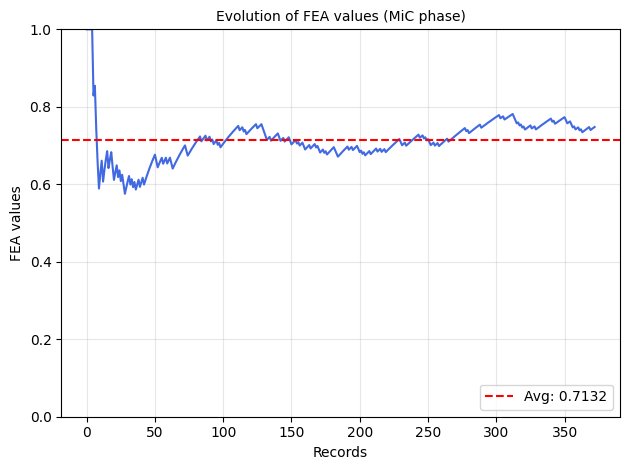

In [ ]:
plt.plot(acc_nt_mic.fea_mic, linestyle='-', color='royalblue')

avg_fea= np.mean(acc_nt_mic.fea_mic)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

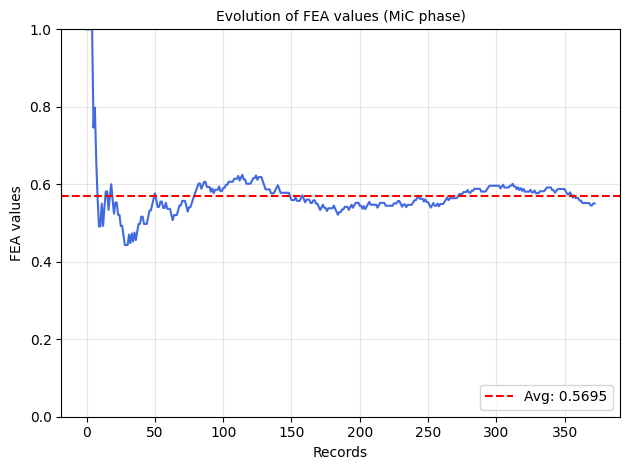

In [ ]:
plt.plot(acc_nt_mic.fea_net, linestyle='-', color='royalblue')

avg_fea= np.mean(acc_nt_mic.fea_net)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [ ]:
acc_nt_mic.deferred_decisions


162

##### Two Stage Deferral

Optimal tau= 0.244068 

In [ ]:
r_net_acc_nt = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff=0.0)

r_net_acc_nt.load_state_dict(torch.load(fr'r_nets/compas/iter_{mic_iter}/r_net_acc_nt.pth'))
r_net_acc_nt.to(device)
r_net_acc_nt.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [ ]:
acc_nt_strat_2= MiC(mic_net, 'Def_Net', 
               benchmark_performance= 65,
                 user_patience= 361,
                 performance_delta= 0.05,
                 belief_threshold= 0.7,
                 tau_threshold= 0.62,
                 anqi_mao_thresh= 0.244068, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= mic_iter
 )



acc_nt_df_2= acc_nt_strat_2.start_MiC(X_stream, y_stream, acc_nt_switch, r_net= r_net_acc_nt, two_step_deferral=True)   #3 minutes

 33%|███▎      | 362/1085 [00:48<01:35,  7.54it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.7
Last 5 FEA values: [0.6441018541203584, 0.6374832379133197, 0.6412073351357566, 0.6448921695135262, 0.638270854720214]


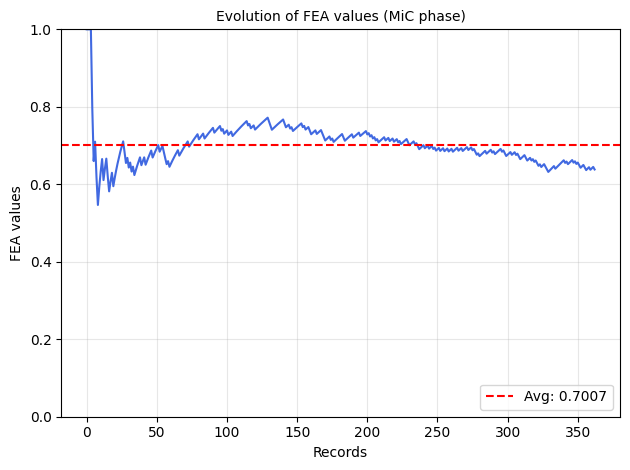

In [ ]:
plt.plot(acc_nt_strat_2.fea_mic, linestyle='-', color='royalblue')
avg_fea_2= np.mean(acc_nt_strat_2.fea_mic)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()



# sospetto che sia uguale no?

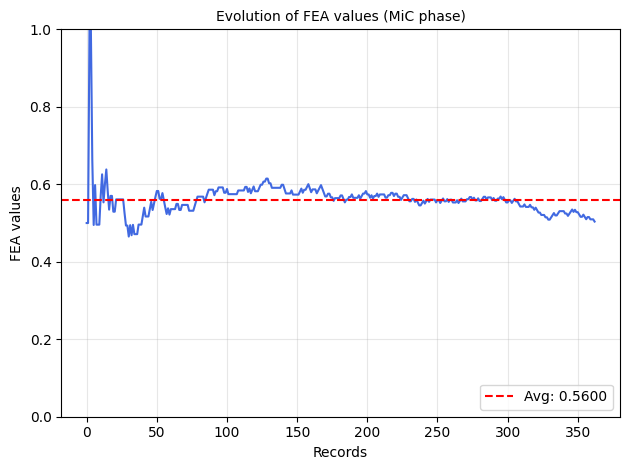

In [ ]:
plt.plot(acc_nt_strat_2.fea_net, linestyle='-', color='royalblue')
avg_fea_2= np.mean(acc_nt_strat_2.fea_net)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()



# sospetto che sia uguale no?

In [ ]:
print(acc_nt_mic.mic_acc)
print(acc_nt_mic.model_acc)
acc_nt_mic.deferred_decisions

0.7265415549597856
0.5361930294906166


162

In [ ]:
print(acc_nt_strat_2.mic_acc)
print(acc_nt_strat_2.model_acc)
acc_nt_strat_2.deferred_decisions


0.6831955922865014
0.5371900826446281


148

In [ ]:
acc_nt_mic.deferred_decisions/len(acc_nt_mic_df)


0.14794520547945206

In [ ]:
acc_nt_strat_2.deferred_decisions/len(acc_nt_df_2)

0.13640552995391705

In [ ]:
acc_nt_mic.stats

{False: {'user': {'tried': 108, 'got': 108, 'conf': 1},
  'machine': {'tried': 119, 'got': 38, 'conf': 0}},
 True: {'user': {'tried': 54, 'got': 54, 'conf': 1},
  'machine': {'tried': 254, 'got': 173, 'conf': 0}}}

In [ ]:
acc_nt_strat_2.stats

{False: {'user': {'tried': 97, 'got': 97, 'conf': 1},
  'machine': {'tried': 114, 'got': 52, 'conf': 0}},
 True: {'user': {'tried': 51, 'got': 51, 'conf': 1},
  'machine': {'tried': 249, 'got': 163, 'conf': 0}}}

#### Iter 2

##### HiC 

previous mean FEA was 0.5843

In [ ]:
#retrieving the trained model

# actually maybe i should train the baseline model again
file_path = r"HIC_res\compas\iter_1\results_accurate_not_trusting\HIC_DRIFT_User_accurate_not_trusting_ARFmodel.pkl"

with open(file_path, "rb") as f:
    prev_arf = pickle.load(f)

In [ ]:
hic_iter= 2

path= fr"HIC_res\compas\iter_1\results_accurate_not_trusting\HIC_DRIFT_User_accurate_not_trusting_ARFpreprocessor.pkl"
previous_preprocessor = joblib.load(path)

current_expert= experts_obj['accurate_not_trusting']
name= f"{'accurate_not_trusting'}"
mod_name="ARF"



hic_inst= HiC(RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, mod_name, prev_arf,
                start_performance= 58.43,
                allocated_budget= 722,
                skepticism_threshold= 0.2,
                performance_delta= 0.05,
                dataset_name= 'compas',
                user_name= name,
                df_batch1=df_batch_1.iloc[722:], df_batch3=mic_data, batch1_test=test_batch_1, 
                target=target, 
                user_model=current_expert, 
                protected=protected, cats=categoricals, num=numericals,
                preprocessor=previous_preprocessor,
                training_iter= hic_iter 
                    )

In [ ]:
acc_nt, _, equality, skept_count= hic_inst.start_HiC(df_avv)  


path= f".\processed_data\compas\hic_results_ds\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"hic_{name}.csv")

acc_nt.to_csv(file_path, index=False)



 51%|█████     | 738/1445 [01:52<01:47,  6.57it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: HiC
Current desired perfomance: 61.3515
Last 5 FEA values: [0.6658089886650044, 0.6691533310700174, 0.6724641816135004, 0.6657347429694054, 0.6590726942360378]


In [ ]:
equality

[]

In [ ]:
skept_count #none overcame the skept threshold set at 0.3

84

In [ ]:
# retrieving the preprocessor
hic_iter= 2
prepr_path= fr"HIC_res\compas\iter_{hic_iter}\results_accurate_not_trusting\HIC_DRIFT_User_accurate_not_trusting_ARFpreprocessor.pkl"
trained_preprocessor = joblib.load(prepr_path)

df_batch_3= scale_df(mic_data, trained_preprocessor, target)
df_batch_3= apply_order(df_batch_3)

df_calibration= scale_df(dfs['calibration'], trained_preprocessor,target)
df_calibration= apply_order(df_calibration)


path= f".\processed_data\compas\calibration_datasets\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"acc_nt_calibration.csv")

df_calibration.to_csv(file_path, index=False)


# applying scaler to calibration batch 3

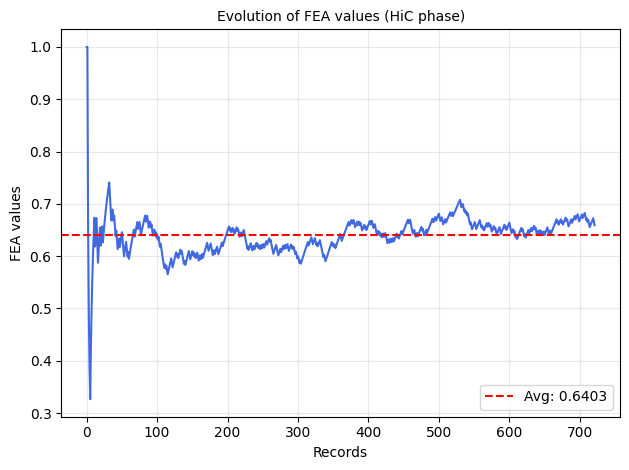

In [ ]:
plt.plot(hic_inst.machine_fea, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_inst.machine_fea)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.axhline(y= avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)  
plt.tight_layout()
plt.show()

# forgot to change the name again 

##### MiC Conf



In [ ]:
mic_iter= 2
acc_nt_switch= pd.read_csv(fr".\processed_data\compas\switch_ds\iter_{mic_iter}\acc_nt_switch.csv")

device = torch.device("cpu")
# prendo la struttura della mic 
mic_net = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=2, dropout_coeff= 0.2) 
mic_net.to(device)



DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [ ]:
X_stream= torch.tensor(data= df_batch_3.drop(columns=['did_recid']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['did_recid'].values, dtype= torch.long).to(device)


net_path= fr"nets\compas\iter_{mic_iter}\acc_nt_models\32_16_acc_nt_model_34.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Confidence based Deferral

Tau = 0.59

previous system FEA (mean): 71.32


new user budget = 361 (prev) + 362

In [ ]:
acc_nt_mic= MiC(mic_net, 'Def_Net', 
                benchmark_performance= 71.32,
                 user_patience= 723,
                 performance_delta= 0.05,
                 belief_threshold= 0.65,
                 tau_threshold= 0.59,
                 anqi_mao_thresh=None, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= 2
 )



acc_nt_mic_df =acc_nt_mic.start_MiC(X_stream, y_stream, acc_nt_switch)   #3 minutes

 67%|██████▋   | 724/1085 [01:03<00:31, 11.34it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.65
Last 5 FEA values: [0.8041902239229544, 0.8061497044585151, 0.7980825714927693, 0.7900962220891368, 0.7921966981163571]


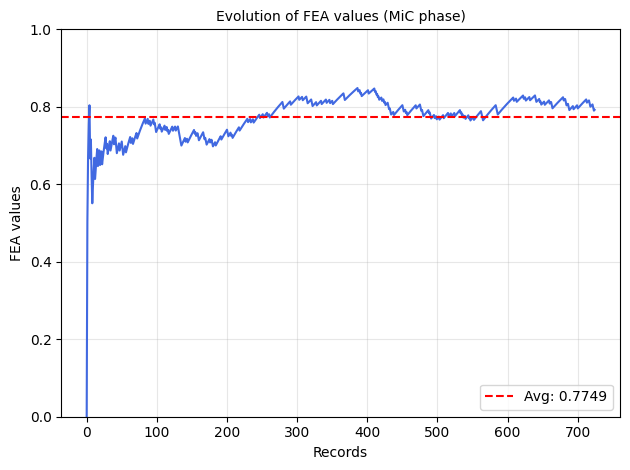

In [ ]:
plt.plot(acc_nt_mic.fea_mic, linestyle='-', color='royalblue')

avg_fea= np.mean(acc_nt_mic.fea_mic)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

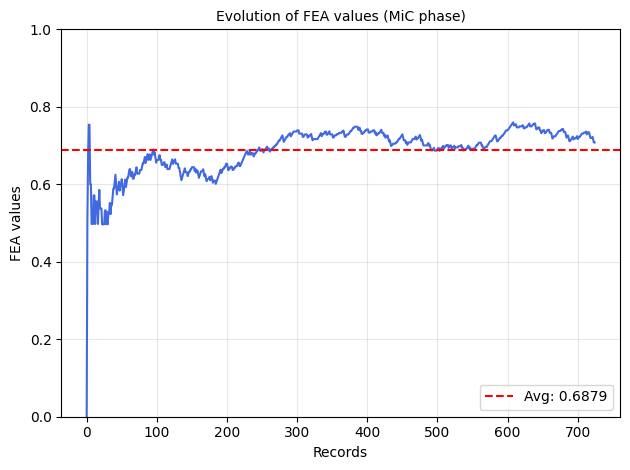

In [ ]:
plt.plot(acc_nt_mic.fea_net, linestyle='-', color='royalblue')

avg_fea= np.mean(acc_nt_mic.fea_net)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [ ]:
acc_nt_mic.low_belief_count

724

##### Two Stage Deferral

Optimal tau= 0.216327

previous system FEA: 70.07

In [ ]:
r_net_acc_nt = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff=0.0)

r_net_acc_nt.load_state_dict(torch.load(fr"r_nets\compas\iter_{mic_iter}\r_net_acc_nt.pth"))
r_net_acc_nt.to(device)
r_net_acc_nt.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [ ]:
acc_nt_strat_2= MiC(mic_net, 'Def_Net', 
                benchmark_performance=70.07,
                 user_patience= 723,
                 performance_delta= 0.05,
                 belief_threshold= 0.65,
                 tau_threshold= 0.0,
                 anqi_mao_thresh= 0.216327, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= 2
 )


acc_nt_df_2= acc_nt_strat_2.start_MiC(X_stream, y_stream, acc_nt_switch, r_net= r_net_acc_nt, two_step_deferral=True)   #3 minutes

 67%|██████▋   | 723/1085 [01:13<00:36,  9.84it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.65
Last 5 FEA values: [0.6958624108065931, 0.6888988229660938, 0.6920120316791671, 0.6850870733958896, 0.6782314610376121]


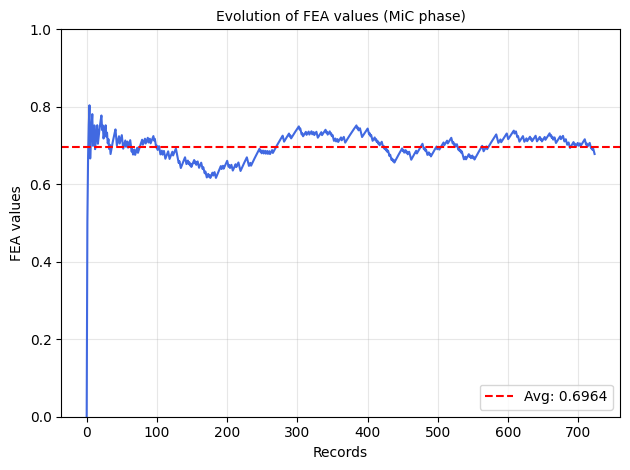

In [ ]:
plt.plot(acc_nt_strat_2.fea_mic, linestyle='-', color='royalblue')
avg_fea_2= np.mean(acc_nt_strat_2.fea_mic)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

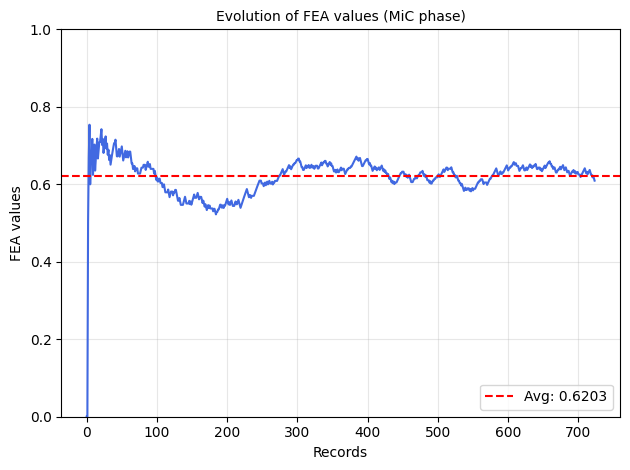

In [ ]:
plt.plot(acc_nt_strat_2.fea_net, linestyle='-', color='royalblue')
avg_fea_2= np.mean(acc_nt_strat_2.fea_net)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [ ]:
print(acc_nt_mic.mic_acc)
print(acc_nt_mic.model_acc)
acc_nt_mic.deferred_decisions

0.7862068965517242
0.646896551724138


261

In [ ]:
print(acc_nt_strat_2.mic_acc)
print(acc_nt_strat_2.model_acc)
acc_nt_strat_2.deferred_decisions


0.6947513812154696
0.6464088397790055


175

In [ ]:
acc_nt_mic.deferred_decisions/len(acc_nt_mic_df)

0.18037318590186593

In [ ]:
acc_nt_strat_2.deferred_decisions/len(acc_nt_df_2)

0.12102351313969571

In [ ]:
acc_nt_mic.stats

{False: {'user': {'tried': 157, 'got': 157, 'conf': 1},
  'machine': {'tried': 392, 'got': 280, 'conf': 0}},
 True: {'user': {'tried': 104, 'got': 104, 'conf': 1},
  'machine': {'tried': 333, 'got': 184, 'conf': 0}}}

In [ ]:
acc_nt_strat_2.stats

{False: {'user': {'tried': 115, 'got': 115, 'conf': 1},
  'machine': {'tried': 391, 'got': 273, 'conf': 0}},
 True: {'user': {'tried': 60, 'got': 60, 'conf': 1},
  'machine': {'tried': 333, 'got': 276, 'conf': 0}}}

#### Iter 3

##### HiC 

previous mean FEA was 0.6403

In [ ]:
#retrieving the trained model

# actually maybe i should train the baseline model again
file_path = r"HIC_res\compas\iter_2\results_accurate_not_trusting\HIC_DRIFT_User_accurate_not_trusting_ARFmodel.pkl"

with open(file_path, "rb") as f:
    prev_arf = pickle.load(f)

In [ ]:

hic_iter= 3
path= fr"HIC_res\compas\iter_2\results_accurate_not_trusting\HIC_DRIFT_User_accurate_not_trusting_ARFpreprocessor.pkl"
previous_preprocessor = joblib.load(path)


current_expert= experts_obj['accurate_not_trusting']
name= f"{'accurate_not_trusting'}"
mod_name="ARF"



hic_inst= HiC(RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, mod_name, prev_arf,
                start_performance= 64.03,
                allocated_budget= 723,
                skepticism_threshold= 0.2,
                performance_delta= 0.05,
                dataset_name= 'compas',
                user_name= name,
                df_batch1=df_batch_1.iloc[1444:], df_batch3=mic_data, batch1_test=test_batch_1, 
                target=target, 
                user_model=current_expert, 
                protected=protected, cats=categoricals, num=numericals,
                preprocessor=previous_preprocessor,
                training_iter= hic_iter 
                    )

In [ ]:
acc_nt, _, equality, skept_count= hic_inst.start_HiC(df_avv)  


path= f".\processed_data\compas\hic_results_ds\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"hic_{name}.csv")

acc_nt.to_csv(file_path, index=False)



100%|██████████| 723/723 [01:46<00:00,  6.78it/s]


In [ ]:
equality

[]

In [ ]:
skept_count #none overcame the skept threshold set at 0.3

102

In [ ]:
# retrieving the preprocessor

prepr_path= fr"HIC_res\compas\iter_3\results_accurate_not_trusting\User_accurate_not_trusting_ARFpreprocessor.pkl"
trained_preprocessor = joblib.load(prepr_path)

df_batch_3= scale_df(mic_data, trained_preprocessor, target)
df_batch_3= apply_order(df_batch_3)

df_calibration= scale_df(dfs['calibration'], trained_preprocessor,target)
df_calibration= apply_order(df_calibration)


path= f".\processed_data\compas\calibration_datasets\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"acc_nt_calibration.csv")

df_calibration.to_csv(file_path, index=False)


# applying scaler to calibration batch 3

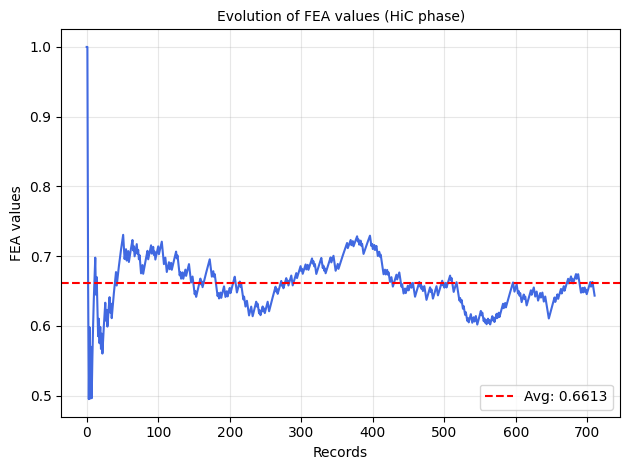

In [ ]:
plt.plot(hic_inst.machine_fea, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_inst.machine_fea)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.axhline(y= avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)  
plt.tight_layout()
plt.show()

# forgot to change the name again 

##### MiC Conf



In [ ]:
mic_iter= 3
acc_nt_switch= pd.read_csv(fr".\processed_data\compas\switch_ds\iter_{mic_iter}\acc_nt_switch.csv")

device = torch.device("cpu")
# prendo la struttura della mic 
mic_net = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=2, dropout_coeff= 0.2) 
mic_net.to(device)



DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [ ]:
X_stream= torch.tensor(data= df_batch_3.drop(columns=['did_recid']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['did_recid'].values, dtype= torch.long).to(device)


net_path= fr"nets\compas\iter_{mic_iter}\acc_nt_models\32_16_acc_nt_model_50.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Confidence based Deferral

Tau = 0.6

previous FEA: 77.49


In [ ]:
acc_nt_mic= MiC(mic_net, 'Def_Net', 
                benchmark_performance= 77.49,
                 user_patience= len(df_batch_3),
                 performance_delta= 0.05,
                 belief_threshold= 0.65,
                 tau_threshold= 0.6,
                 anqi_mao_thresh=None, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= 3
 )



acc_nt_mic_df =acc_nt_mic.start_MiC(X_stream, y_stream, acc_nt_switch)   #3 minutes

100%|██████████| 1085/1085 [01:30<00:00, 11.97it/s]


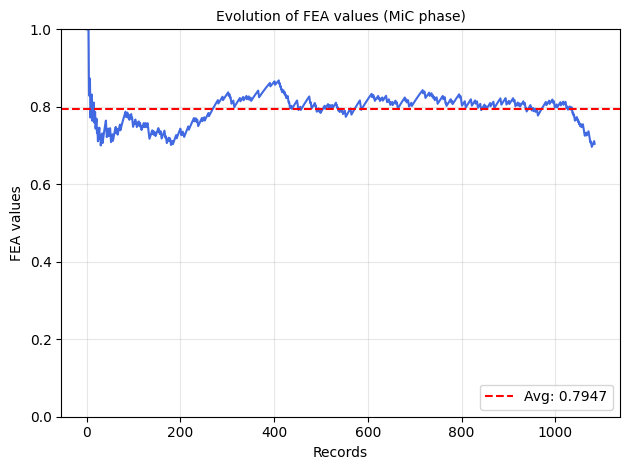

In [ ]:
plt.plot(acc_nt_mic.fea_mic, linestyle='-', color='royalblue')

avg_fea= np.mean(acc_nt_mic.fea_mic)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

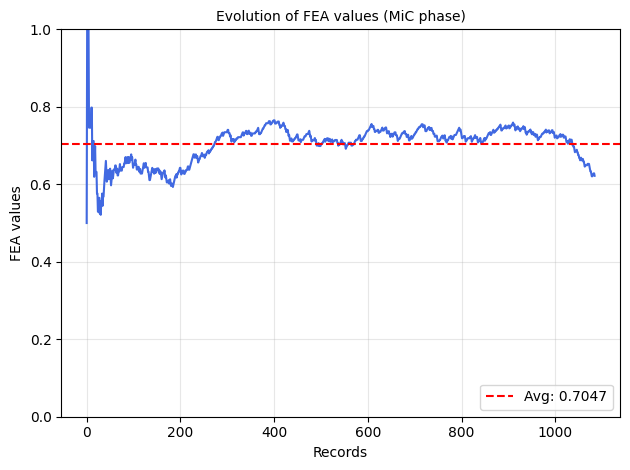

In [ ]:
plt.plot(acc_nt_mic.fea_net, linestyle='-', color='royalblue')

avg_fea= np.mean(acc_nt_mic.fea_net)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [ ]:
acc_nt_mic.low_belief_count

1045

##### Two Stage Deferral

Optimal tau= 0.230612


Previous FEA: 69.64

In [ ]:
r_net_acc_nt = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff=0.0)

r_net_acc_nt.load_state_dict(torch.load(fr"r_nets\compas\iter_{mic_iter}\r_net_acc_nt.pth"))
r_net_acc_nt.to(device)
r_net_acc_nt.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [ ]:
acc_nt_strat_3= MiC(mic_net, 'Def_Net', 
                benchmark_performance= 69.64,
                 user_patience= len(df_batch_3),
                 performance_delta= 0.05,
                 belief_threshold= 0.65,
                 tau_threshold= 0.0,
                 anqi_mao_thresh= 0.230612, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= 3
 )



acc_nt_df_3= acc_nt_strat_3.start_MiC(X_stream, y_stream, acc_nt_switch, r_net= r_net_acc_nt, two_step_deferral=True)   #3 minutes

100%|██████████| 1085/1085 [01:44<00:00, 10.38it/s]


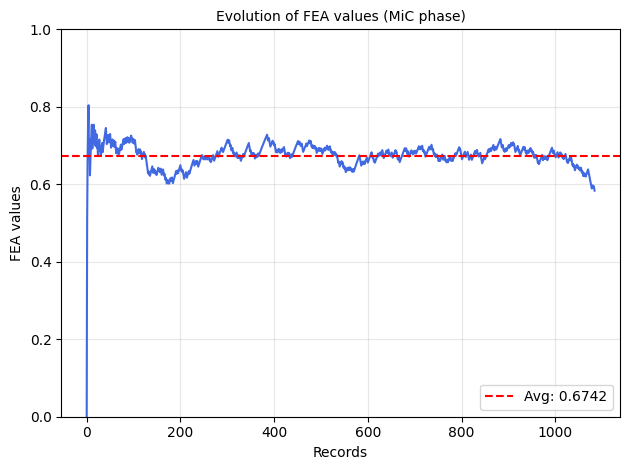

In [ ]:
plt.plot(acc_nt_strat_3.fea_mic, linestyle='-', color='royalblue')
avg_fea_3= np.mean(acc_nt_strat_3.fea_mic)
plt.axhline(y=avg_fea_3, color='red', linestyle='--', label=f'Avg: {avg_fea_3:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

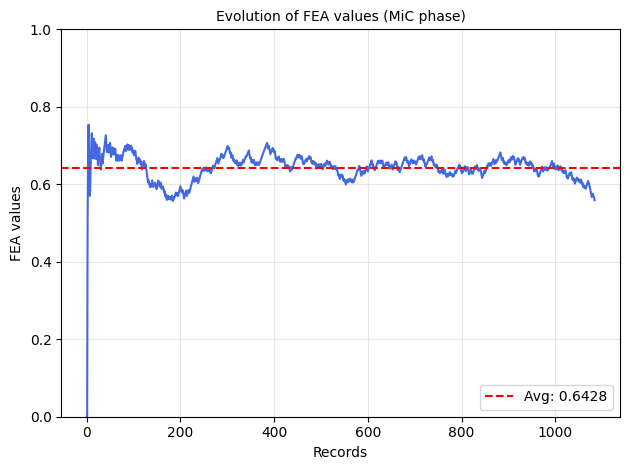

In [ ]:
plt.plot(acc_nt_strat_3.fea_net, linestyle='-', color='royalblue')
avg_fea_3= np.mean(acc_nt_strat_3.fea_net)
plt.axhline(y=avg_fea_3, color='red', linestyle='--', label=f'Avg: {avg_fea_3:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [ ]:
print(acc_nt_mic.mic_acc)
print(acc_nt_mic.model_acc)
acc_nt_mic.deferred_decisions

0.7889400921658987
0.6497695852534562


396

In [ ]:
print(acc_nt_strat_3.mic_acc)
print(acc_nt_strat_3.model_acc)
acc_nt_strat_3.deferred_decisions


0.6654377880184332
0.6497695852534562


117

In [ ]:
acc_nt_mic.deferred_decisions /len(acc_nt_mic_df)

0.22048997772828507

In [ ]:
acc_nt_strat_3.deferred_decisions/len(acc_nt_df_2)

0.08091286307053942

In [ ]:
acc_nt_mic.stats

{False: {'user': {'tried': 228, 'got': 228, 'conf': 1},
  'machine': {'tried': 638, 'got': 433, 'conf': 0}},
 True: {'user': {'tried': 168, 'got': 168, 'conf': 1},
  'machine': {'tried': 447, 'got': 256, 'conf': 0}}}

In [ ]:
acc_nt_strat_3.stats

{False: {'user': {'tried': 82, 'got': 82, 'conf': 1},
  'machine': {'tried': 638, 'got': 533, 'conf': 0}},
 True: {'user': {'tried': 35, 'got': 35, 'conf': 1},
  'machine': {'tried': 447, 'got': 435, 'conf': 0}}}

### Expert: Inaccurate, Not Trusting 

#### Iter 1

##### HiC, 722 record batch

In [18]:
# defining necessary instantiation params for HiC class
hic_iter= 1

clean_prepr = copy.deepcopy(prepr_transf)
arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['inaccurate_not_trusting']
name= "inaccurate_not_trusting"
mod_name="ARF"


hic_inst= HiC(RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, 
                mod_name, arf_mod,
                start_performance= 65,
                allocated_budget= 722,
                skepticism_threshold= 0.2,
                performance_delta= 0.05,
                dataset_name= 'compas',
                user_name= name,
                df_batch1=df_batch_1, df_batch3=mic_data, batch1_test=test_batch_1, 
                target=target, 
                user_model=current_expert, 
                protected=protected, cats=categoricals, num=numericals,
                preprocessor=prepr_transf,
                training_iter= hic_iter 
                    )

In [19]:
inacc_nt, _, equality, skept_count= hic_inst.start_HiC(df_avv)  

# saving the results in their folder 
path= f".\processed_data\compas\hic_results_ds\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"hic_{name}.csv")

inacc_nt.to_csv(file_path, index=False)

 34%|███▍      | 733/2167 [01:23<02:43,  8.77it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: HiC
Current desired perfomance: 68.25
Last 5 FEA values: [0.6247752980092534, 0.6285302759701002, 0.6322476497664561, 0.6359277965233888, 0.6395710895731211]


In [20]:
equality

[]

In [21]:
skept_count #none overcame the skept threshold set at 0.6

71

Applying learned scaler to the calibration and mic batches

In [22]:
# retrieving the preprocessor

prepr_path= fr"HIC_res\compas\iter_{hic_iter}\results_inaccurate_not_trusting\HIC_DRIFT_User_inaccurate_not_trusting_ARFpreprocessor.pkl"
trained_preprocessor = joblib.load(prepr_path)

df_batch_3= scale_df(mic_data, trained_preprocessor, target)
df_batch_3= apply_order(df_batch_3)

df_calibration= scale_df(dfs['calibration'], trained_preprocessor,target)
df_calibration= apply_order(df_calibration)


path= f".\processed_data\compas\calibration_datasets\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"inacc_nt_calibration.csv")

df_calibration.to_csv(file_path, index=False)


# applying scaler to calibration batch 3

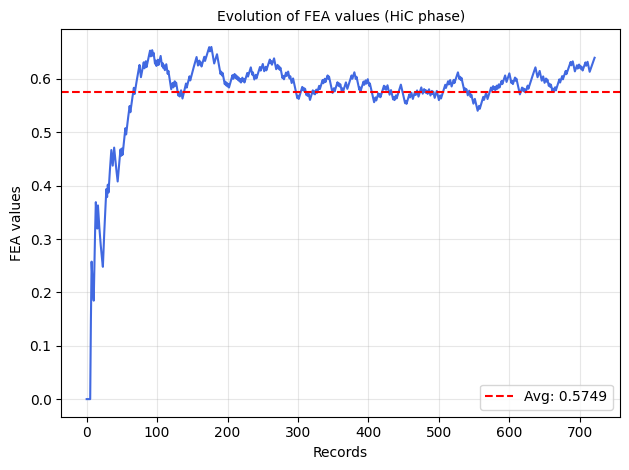

In [23]:
plt.plot(hic_inst.machine_fea, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_inst.machine_fea)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.axhline(y= avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)  
plt.tight_layout()
plt.show()

# forgot to change the name again 

##### MiC

In [40]:
mic_iter= 1

inacc_nt_switch= pd.read_csv(fr".\processed_data\compas\switch_ds\iter_{mic_iter}\inacc_nt_switch.csv")

device = torch.device("cpu")
# prendo la struttura della mic 
mic_net = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=2, dropout_coeff= 0.0) #tanto va in eval non serve il dropout
mic_net.to(device)


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [41]:
X_stream= torch.tensor(data= df_batch_3.drop(columns=['did_recid']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['did_recid'].values, dtype= torch.long).to(device)


net_path= fr".\nets\compas\iter_{mic_iter}\inacc_nt_models\32_16_inacc_nt_model_50.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Confidence based Deferral

Tau = 0.62

In [26]:
inacc_nt_mic= MiC(mic_net, 'Def_Net', 
               benchmark_performance= 65, #nel primo run è irrilevante
                 user_patience= 361,
                 performance_delta= 0.05,
                 belief_threshold= 0.6,
                 tau_threshold= 0.62,
                 anqi_mao_thresh=None, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= mic_iter
 )



inacc_nt_mic_df =inacc_nt_mic.start_MiC(X_stream, y_stream, inacc_nt_switch)   #3 minutes

 33%|███▎      | 361/1085 [00:40<01:21,  8.93it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.6
Last 5 FEA values: [0.6718554709790238, 0.675228334676722, 0.6682898711856543, 0.6716974950490614, 0.6647990986669751]


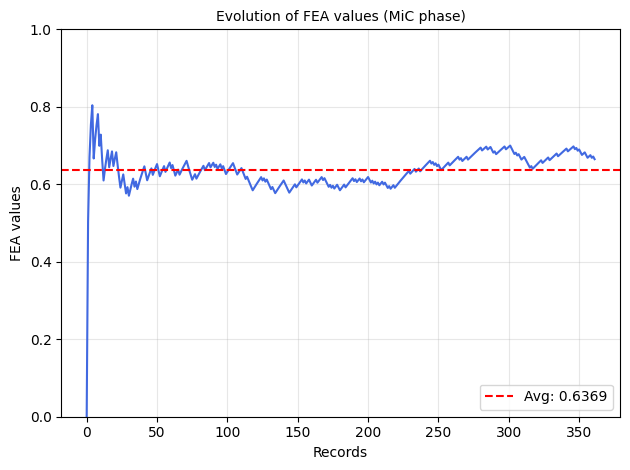

In [27]:
plt.plot(inacc_nt_mic.fea_mic, linestyle='-', color='royalblue')

avg_fea= np.mean(inacc_nt_mic.fea_mic)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

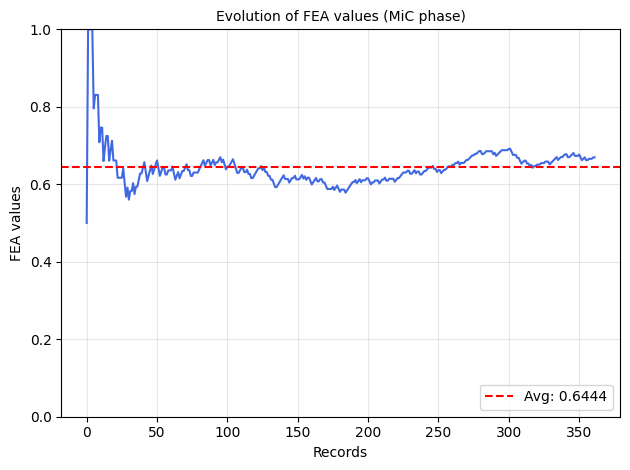

In [28]:
plt.plot(inacc_nt_mic.fea_net, linestyle='-', color='royalblue')

avg_fea= np.mean(inacc_nt_mic.fea_net)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [29]:
inacc_nt_mic.deferred_decisions


116

##### Two Stage Deferral

Optimal tau= 0.216949

In [42]:
r_net_inacc_nt = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff=0.0)

r_net_inacc_nt.load_state_dict(torch.load(fr'r_nets/compas/iter_{mic_iter}/r_net_inacc_nt.pth'))
r_net_inacc_nt.to(device)
r_net_inacc_nt.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [43]:
inacc_nt_strat_2= MiC(mic_net, 'Def_Net', 
               benchmark_performance= 65,
                 user_patience= 361,
                 performance_delta= 0.05,
                 belief_threshold= 0.7,
                 tau_threshold= 0.62,
                 anqi_mao_thresh= 0.216949, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= mic_iter
 )



inacc_nt_df_2= inacc_nt_strat_2.start_MiC(X_stream, y_stream, inacc_nt_switch, r_net= r_net_inacc_nt, two_step_deferral=True)   #3 minutes

 33%|███▎      | 361/1085 [00:42<01:25,  8.46it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.7
Last 5 FEA values: [0.6610418405577235, 0.6542472612504625, 0.6475243935874954, 0.6511453390556767, 0.6547281091994845]


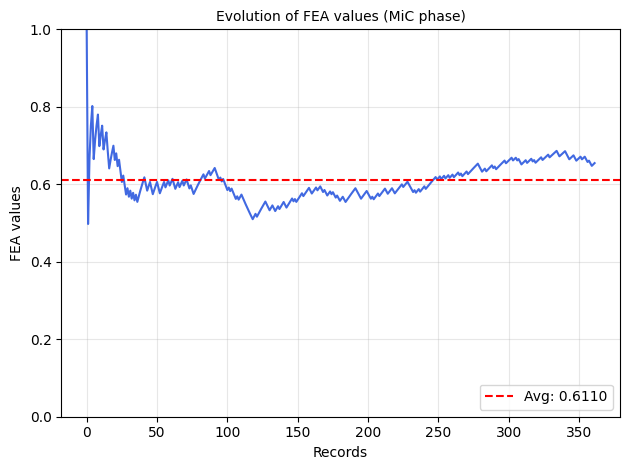

In [44]:
plt.plot(inacc_nt_strat_2.fea_mic, linestyle='-', color='royalblue')
avg_fea_2= np.mean(inacc_nt_strat_2.fea_mic)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()



# sospetto che sia uguale no?

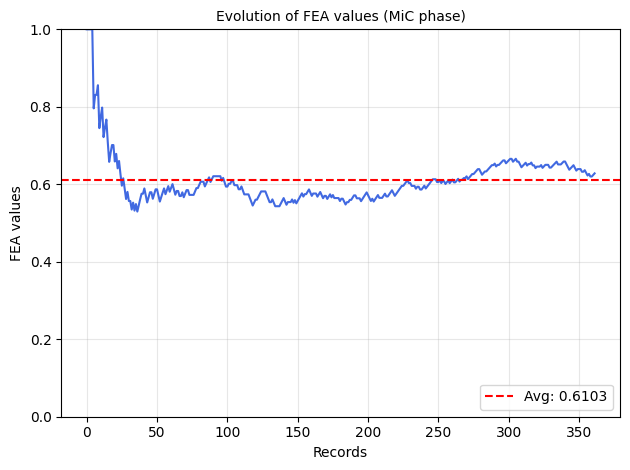

In [45]:
plt.plot(inacc_nt_strat_2.fea_net, linestyle='-', color='royalblue')
avg_fea_2= np.mean(inacc_nt_strat_2.fea_net)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()



# sospetto che sia uguale no?

In [46]:
print(inacc_nt_mic.mic_acc)
print(inacc_nt_mic.model_acc)
inacc_nt_mic.deferred_decisions

0.6464088397790055
0.6298342541436464


116

In [47]:
print(inacc_nt_strat_2.mic_acc)
print(inacc_nt_strat_2.model_acc)
inacc_nt_strat_2.deferred_decisions


0.6215469613259669
0.6298342541436464


91

In [48]:
inacc_nt_mic.deferred_decisions/len(inacc_nt_mic_df)


0.1070110701107011

In [49]:
inacc_nt_strat_2.deferred_decisions/len(inacc_nt_df_2)

0.08394833948339483

In [50]:
inacc_nt_mic.stats

{False: {'user': {'tried': 67, 'got': 67, 'conf': 1},
  'machine': {'tried': 193, 'got': 134, 'conf': 0}},
 True: {'user': {'tried': 49, 'got': 49, 'conf': 1},
  'machine': {'tried': 169, 'got': 112, 'conf': 0}}}

In [51]:
inacc_nt_strat_2.stats

{False: {'user': {'tried': 57, 'got': 57, 'conf': 1},
  'machine': {'tried': 193, 'got': 143, 'conf': 0}},
 True: {'user': {'tried': 34, 'got': 34, 'conf': 1},
  'machine': {'tried': 169, 'got': 128, 'conf': 0}}}

#### Iter 2

##### HiC 

previous mean FEA was 0.5749

In [52]:
#retrieving the trained model

# actually maybe i should train the baseline model again
file_path = r"HIC_res\compas\iter_1\results_inaccurate_not_trusting\HIC_DRIFT_User_inaccurate_not_trusting_ARFmodel.pkl"

with open(file_path, "rb") as f:
    prev_arf = pickle.load(f)

In [53]:
hic_iter= 2

path= fr"HIC_res\compas\iter_1\results_inaccurate_not_trusting\HIC_DRIFT_User_inaccurate_not_trusting_ARFpreprocessor.pkl"
previous_preprocessor = joblib.load(path)

current_expert= experts_obj['inaccurate_not_trusting']
name= f"{'inaccurate_not_trusting'}"
mod_name="ARF"



hic_inst= HiC(RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, mod_name, prev_arf,
                start_performance= 57.49,
                allocated_budget= 722,
                skepticism_threshold= 0.2,
                performance_delta= 0.05,
                dataset_name= 'compas',
                user_name= name,
                df_batch1=df_batch_1.iloc[722:], df_batch3=mic_data, batch1_test=test_batch_1, 
                target=target, 
                user_model=current_expert, 
                protected=protected, cats=categoricals, num=numericals,
                preprocessor=previous_preprocessor,
                training_iter= hic_iter 
                    )

In [54]:
inacc_nt, _, equality, skept_count= hic_inst.start_HiC(df_avv)  


path= f".\processed_data\compas\hic_results_ds\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"hic_{name}.csv")

inacc_nt.to_csv(file_path, index=False)



 51%|█████     | 738/1445 [01:45<01:40,  7.02it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: HiC
Current desired perfomance: 60.3645
Last 5 FEA values: [0.6406928121548324, 0.6442884991241986, 0.6478481771460651, 0.6413650741377641, 0.6349468941871015]


In [55]:
equality

[]

In [56]:
skept_count #none overcame the skept threshold set at 0.3

136

In [57]:
# retrieving the preprocessor
hic_iter= 2
prepr_path= fr"HIC_res\compas\iter_{hic_iter}\results_inaccurate_not_trusting\HIC_DRIFT_User_inaccurate_not_trusting_ARFpreprocessor.pkl"
trained_preprocessor = joblib.load(prepr_path)

df_batch_3= scale_df(mic_data, trained_preprocessor, target)
df_batch_3= apply_order(df_batch_3)

df_calibration= scale_df(dfs['calibration'], trained_preprocessor,target)
df_calibration= apply_order(df_calibration)


path= f".\processed_data\compas\calibration_datasets\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"inacc_nt_calibration.csv")

df_calibration.to_csv(file_path, index=False)


# applying scaler to calibration batch 3

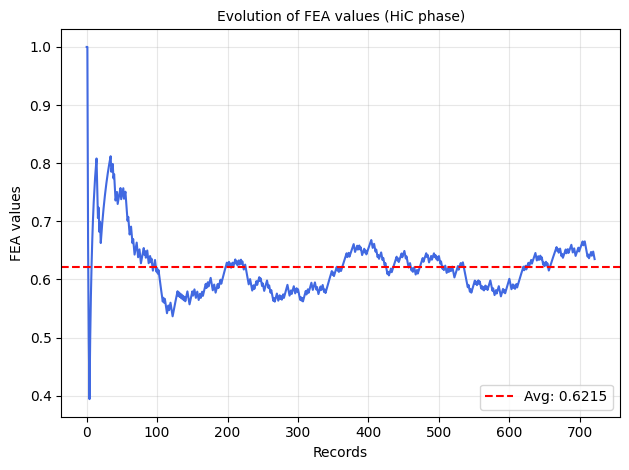

In [58]:
plt.plot(hic_inst.machine_fea, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_inst.machine_fea)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.axhline(y= avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)  
plt.tight_layout()
plt.show()

# forgot to change the name again 

##### MiC Conf



In [85]:
mic_iter= 2
inacc_nt_switch= pd.read_csv(fr".\processed_data\compas\switch_ds\iter_{mic_iter}\inacc_nt_switch.csv")

device = torch.device("cpu")
# prendo la struttura della mic 
mic_net = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=2, dropout_coeff= 0.2) 
mic_net.to(device)



DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [86]:
X_stream= torch.tensor(data= df_batch_3.drop(columns=['did_recid']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['did_recid'].values, dtype= torch.long).to(device)


net_path= fr"nets\compas\iter_{mic_iter}\inacc_nt_models\32_16_inacc_nt_model_50.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Confidence based Deferral

Tau = 0.58

previous system FEA (mean): 63.69


In [61]:
inacc_nt_mic= MiC(mic_net, 'Def_Net', 
                benchmark_performance= 63.69,
                 user_patience= 723,
                 performance_delta= 0.05,
                 belief_threshold= 0.65,
                 tau_threshold= 0.58,
                 anqi_mao_thresh=None, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= 2
 )



inacc_nt_mic_df =inacc_nt_mic.start_MiC(X_stream, y_stream, inacc_nt_switch)   #3 minutes

 67%|██████▋   | 723/1085 [01:58<00:59,  6.09it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.65
Last 5 FEA values: [0.7069896839415535, 0.699914743996533, 0.7029177157067718, 0.6958836243398417, 0.6889199717470417]


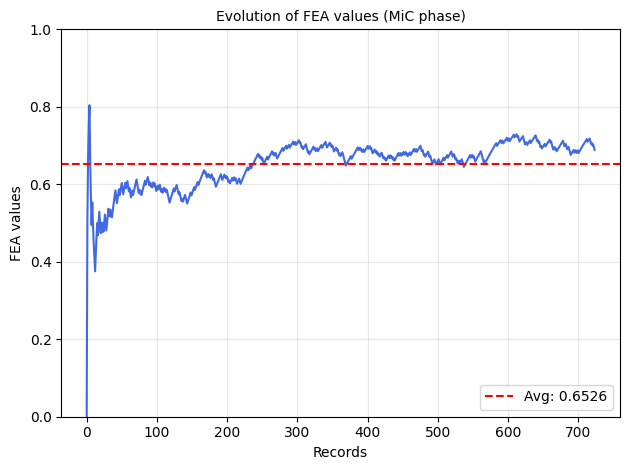

In [62]:
plt.plot(inacc_nt_mic.fea_mic, linestyle='-', color='royalblue')

avg_fea= np.mean(inacc_nt_mic.fea_mic)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

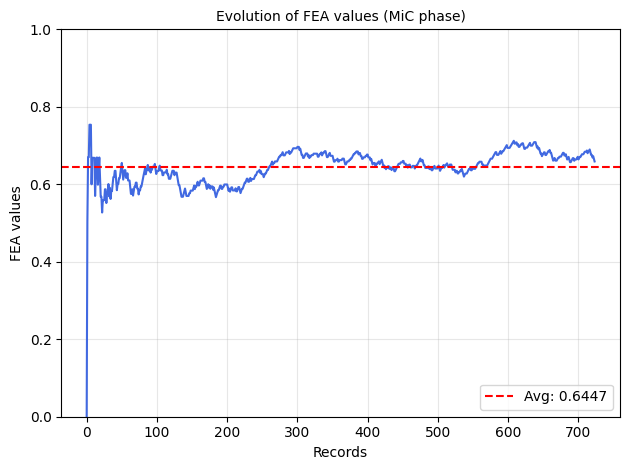

In [63]:
plt.plot(inacc_nt_mic.fea_net, linestyle='-', color='royalblue')

avg_fea= np.mean(inacc_nt_mic.fea_net)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [64]:
inacc_nt_mic.low_belief_count

724

##### Two Stage Deferral

Optimal tau= 0.216327

previous system FEA: 61.10

In [87]:
r_net_inacc_nt = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff=0.0)

r_net_inacc_nt.load_state_dict(torch.load(fr"r_nets\compas\iter_{mic_iter}\r_net_inacc_nt.pth"))
r_net_inacc_nt.to(device)
r_net_inacc_nt.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [88]:
inacc_nt_strat_2= MiC(mic_net, 'Def_Net', 
                benchmark_performance=61.10,
                 user_patience= 723,
                 performance_delta= 0.05,
                 belief_threshold= 0.65,
                 tau_threshold= 0.0,
                 anqi_mao_thresh= 0.240816, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= 2
 )


inacc_nt_df_2= inacc_nt_strat_2.start_MiC(X_stream, y_stream, inacc_nt_switch, r_net= r_net_inacc_nt, two_step_deferral=True)   #3 minutes

 67%|██████▋   | 723/1085 [01:39<00:49,  7.26it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.65
Last 5 FEA values: [0.6641650669675375, 0.6575186786692265, 0.660945910426423, 0.6543318305438816, 0.6477839834772959]


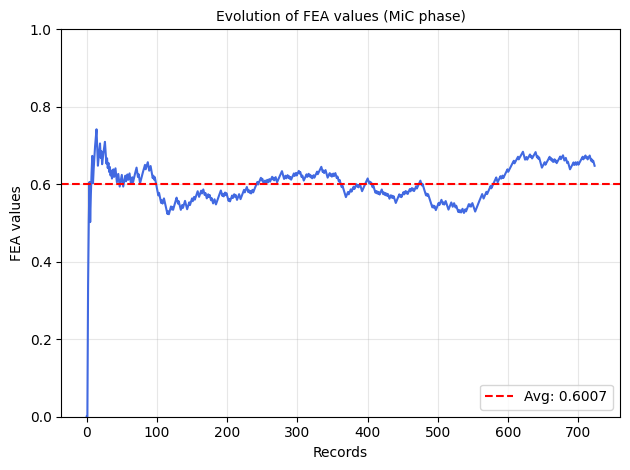

In [89]:
plt.plot(inacc_nt_strat_2.fea_mic, linestyle='-', color='royalblue')
avg_fea_2= np.mean(inacc_nt_strat_2.fea_mic)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

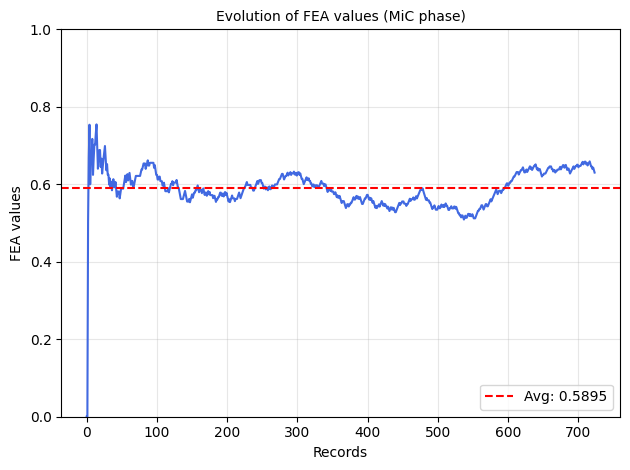

In [90]:
plt.plot(inacc_nt_strat_2.fea_net, linestyle='-', color='royalblue')
avg_fea_2= np.mean(inacc_nt_strat_2.fea_net)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [91]:
print(inacc_nt_mic.mic_acc)
print(inacc_nt_mic.model_acc)
inacc_nt_mic.deferred_decisions

0.6685082872928176
0.611878453038674


268

In [92]:
print(inacc_nt_strat_2.mic_acc)
print(inacc_nt_strat_2.model_acc)
inacc_nt_strat_2.deferred_decisions


0.6077348066298343
0.611878453038674


191

In [93]:
inacc_nt_mic.deferred_decisions/len(inacc_nt_mic_df)

0.18533886583679116

In [94]:
inacc_nt_strat_2.deferred_decisions/len(inacc_nt_df_2)

0.13208852005532504

In [95]:
inacc_nt_mic.stats

{False: {'user': {'tried': 161, 'got': 161, 'conf': 1},
  'machine': {'tried': 312, 'got': 206, 'conf': 0}},
 True: {'user': {'tried': 107, 'got': 107, 'conf': 1},
  'machine': {'tried': 412, 'got': 250, 'conf': 0}}}

In [96]:
inacc_nt_strat_2.stats

{False: {'user': {'tried': 100, 'got': 100, 'conf': 1},
  'machine': {'tried': 312, 'got': 249, 'conf': 0}},
 True: {'user': {'tried': 91, 'got': 91, 'conf': 1},
  'machine': {'tried': 412, 'got': 284, 'conf': 0}}}

#### Iter 3

##### HiC 

previous mean FEA was 62.15

In [97]:
#retrieving the trained model

# actually maybe i should train the baseline model again
file_path = r"HIC_res\compas\iter_2\results_inaccurate_not_trusting\HIC_DRIFT_User_inaccurate_not_trusting_ARFmodel.pkl"

with open(file_path, "rb") as f:
    prev_arf = pickle.load(f)

In [98]:

hic_iter= 3
path= fr"HIC_res\compas\iter_2\results_inaccurate_not_trusting\HIC_DRIFT_User_inaccurate_not_trusting_ARFpreprocessor.pkl"
previous_preprocessor = joblib.load(path)


current_expert= experts_obj['inaccurate_not_trusting']
name= f"{'inaccurate_not_trusting'}"
mod_name="ARF"



hic_inst= HiC(RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, mod_name, prev_arf,
                start_performance= 62.15,
                allocated_budget= 723,
                skepticism_threshold= 0.2,
                performance_delta= 0.05,
                dataset_name= 'compas',
                user_name= name,
                df_batch1=df_batch_1.iloc[1444:], df_batch3=mic_data, batch1_test=test_batch_1, 
                target=target, 
                user_model=current_expert, 
                protected=protected, cats=categoricals, num=numericals,
                preprocessor=previous_preprocessor,
                training_iter= hic_iter 
                    )

In [99]:
inacc_nt, _, equality, skept_count= hic_inst.start_HiC(df_avv)  


path= f".\processed_data\compas\hic_results_ds\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"hic_{name}.csv")

inacc_nt.to_csv(file_path, index=False)



100%|██████████| 723/723 [01:42<00:00,  7.03it/s]


In [100]:
equality

[]

In [101]:
skept_count #none overcame the skept threshold set at 0.3

174

In [102]:
# retrieving the preprocessor

prepr_path= fr"HIC_res\compas\iter_3\results_inaccurate_not_trusting\User_inaccurate_not_trusting_ARFpreprocessor.pkl"
trained_preprocessor = joblib.load(prepr_path)

df_batch_3= scale_df(mic_data, trained_preprocessor, target)
df_batch_3= apply_order(df_batch_3)

df_calibration= scale_df(dfs['calibration'], trained_preprocessor,target)
df_calibration= apply_order(df_calibration)


path= f".\processed_data\compas\calibration_datasets\iter_{hic_iter}"
os.makedirs(path, exist_ok=True)
file_path = os.path.join(path, f"inacc_nt_calibration.csv")

df_calibration.to_csv(file_path, index=False)


# applying scaler to calibration batch 3

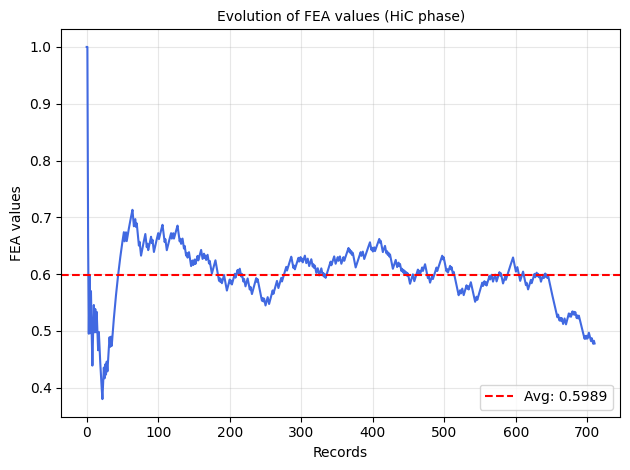

In [103]:
plt.plot(hic_inst.machine_fea, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_inst.machine_fea)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.axhline(y= avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)  
plt.tight_layout()
plt.show()

# forgot to change the name again 

##### MiC Conf



In [124]:
mic_iter= 3
inacc_nt_switch= pd.read_csv(fr".\processed_data\compas\switch_ds\iter_{mic_iter}\inacc_nt_switch.csv")

device = torch.device("cpu")
# prendo la struttura della mic 
mic_net = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=2, dropout_coeff= 0.2) 
mic_net.to(device)



DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

In [125]:
X_stream= torch.tensor(data= df_batch_3.drop(columns=['did_recid']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['did_recid'].values, dtype= torch.long).to(device)


net_path= fr"nets\compas\iter_{mic_iter}\inacc_nt_models\32_16_inacc_nt_model_50.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
)

##### Confidence based Deferral

Tau = 0.57

previous FEA: 65.26


In [106]:
inacc_nt_mic= MiC(mic_net, 'Def_Net', 
                benchmark_performance= 65.26,
                 user_patience= len(df_batch_3),
                 performance_delta= 0.05,
                 belief_threshold= 0.65,
                 tau_threshold= 0.57,
                 anqi_mao_thresh=None, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= 3
 )



inacc_nt_mic_df =inacc_nt_mic.start_MiC(X_stream, y_stream, inacc_nt_switch)   #3 minutes

100%|██████████| 1085/1085 [01:12<00:00, 14.93it/s]


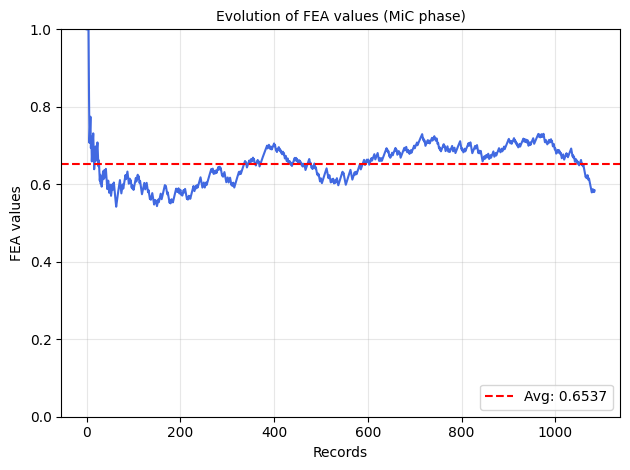

In [107]:
plt.plot(inacc_nt_mic.fea_mic, linestyle='-', color='royalblue')

avg_fea= np.mean(inacc_nt_mic.fea_mic)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

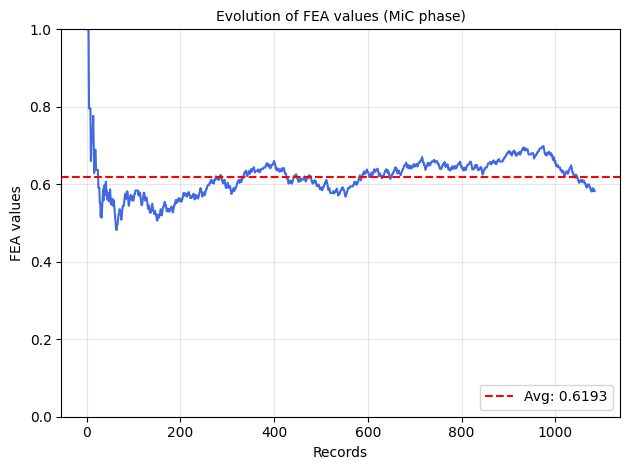

In [108]:
plt.plot(inacc_nt_mic.fea_net, linestyle='-', color='royalblue')

avg_fea= np.mean(inacc_nt_mic.fea_net)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [109]:
inacc_nt_mic.low_belief_count

1084

##### Two Stage Deferral

Optimal tau= 0.230612


Previous FEA: 60.07

In [126]:
r_net_inacc_nt = DeferralNet(input_size=8, hidden_layer1=32, hidden_layer2=16, output_size=1, dropout_coeff=0.0)

r_net_inacc_nt.load_state_dict(torch.load(fr"r_nets\compas\iter_{mic_iter}\r_net_inacc_nt.pth"))
r_net_inacc_nt.to(device)
r_net_inacc_nt.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
  )
)

In [127]:
inacc_nt_strat_3= MiC(mic_net, 'Def_Net', 
                benchmark_performance= 60.07,
                 user_patience= len(df_batch_3),
                 performance_delta= 0.05,
                 belief_threshold= 0.65,
                 tau_threshold= 0.0,
                 anqi_mao_thresh= 0.272857, 
                 dataset_name= 'compas', 
                 user_name=name, 
                 df_batch1=df_batch_1, df_batch3=df_batch_3, batch1_test=test_batch_1, 
                 target=target, 
                 user_model=current_expert, 
                 protected=protected, cats=categoricals, num=numericals,
                 preprocessor=trained_preprocessor,
                 training_iter= 3
 )



inacc_nt_df_3= inacc_nt_strat_3.start_MiC(X_stream, y_stream, inacc_nt_switch, r_net= r_net_inacc_nt, two_step_deferral=True)   #3 minutes

100%|██████████| 1085/1085 [01:12<00:00, 14.88it/s]


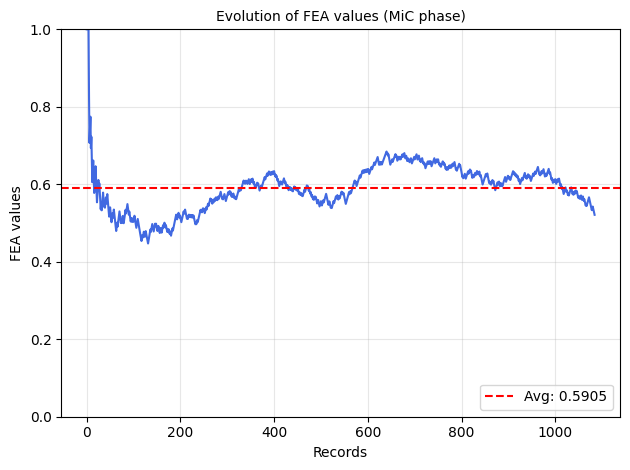

In [128]:
plt.plot(inacc_nt_strat_3.fea_mic, linestyle='-', color='royalblue')
avg_fea_3= np.mean(inacc_nt_strat_3.fea_mic)
plt.axhline(y=avg_fea_3, color='red', linestyle='--', label=f'Avg: {avg_fea_3:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

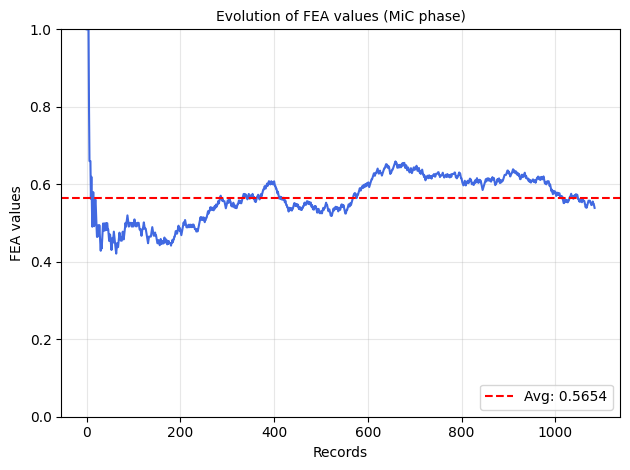

In [129]:
plt.plot(inacc_nt_strat_3.fea_net, linestyle='-', color='royalblue')
avg_fea_3= np.mean(inacc_nt_strat_3.fea_net)
plt.axhline(y=avg_fea_3, color='red', linestyle='--', label=f'Avg: {avg_fea_3:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [132]:
print(inacc_nt_mic.mic_acc)
print(inacc_nt_mic.model_acc)
inacc_nt_mic.deferred_decisions

0.6488479262672812
0.5741935483870968


408

In [133]:
print(inacc_nt_strat_3.mic_acc)
print(inacc_nt_strat_3.model_acc)
inacc_nt_strat_3.deferred_decisions


0.5861751152073733
0.5741935483870968


240

In [134]:
inacc_nt_mic.deferred_decisions /len(inacc_nt_mic_df)

0.22717149220489977

In [135]:
inacc_nt_strat_3.deferred_decisions/len(inacc_nt_df_2)

0.16597510373443983

In [136]:
inacc_nt_mic.stats

{False: {'user': {'tried': 226, 'got': 226, 'conf': 1},
  'machine': {'tried': 496, 'got': 313, 'conf': 0}},
 True: {'user': {'tried': 182, 'got': 182, 'conf': 1},
  'machine': {'tried': 589, 'got': 364, 'conf': 0}}}

In [137]:
inacc_nt_strat_3.stats

{False: {'user': {'tried': 128, 'got': 128, 'conf': 1},
  'machine': {'tried': 496, 'got': 413, 'conf': 0}},
 True: {'user': {'tried': 112, 'got': 112, 'conf': 1},
  'machine': {'tried': 589, 'got': 432, 'conf': 0}}}